# IMPORT LIBRARIES 

In [121]:
import pandas as pd
import numpy as np
import xarray as xr
import scipy   

import os
#from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [122]:
from pyaldata import *

# LOAD DATA

In [123]:
data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_data = os.path.join(data_dir, "Mihili_RT_FF_2014-02-14_2.mat")
data=mat2dataframe(fname_data, shift_idx_fields=True)
binsize = 20 # binsize in ms

In [124]:
concat_trials(data, 'pos').min(axis=0) #min x y coord  

array([ -6.78328513, -42.04504891])

In [125]:
concat_trials(data, 'pos').max(axis=0) #max x y coord 

array([ 12.76527179, -23.35597218])

In [126]:
#data.head()
data.columns

Index(['monkey', 'date', 'task', 'target_center', 'trial_id', 'result',
       'bin_size', 'perturbation', 'epoch', 'perturbation_info',
       'idx_trial_start', 'idx_go_cue', 'idx_trial_end', 'pos', 'vel', 'acc',
       'force', 'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide'],
      dtype='object')

In [127]:
#DOWNSAMPLING: 
#data['bin_size'] = data['bin_size'].replace([0.01],0.02)
#for trial in range(0, 741): 
#    data[trial].bin_size=0.03

data.bin_size # 0.01

0      0.01
1      0.01
2      0.01
3      0.01
4      0.01
       ... 
736    0.01
737    0.01
738    0.01
739    0.01
740    0.01
Name: bin_size, Length: 741, dtype: float64

# CORRECTION 

In [128]:
#for this data frame each trial =  4 (x,y) target reaching task 
""" target of each trial stored in target_center - must correct them """
data.target_center[0].shape #4 targets in space, 2(x,y)
for trial in range (0, 741): 
    targets=data.target_center[trial]
    targets=targets.flatten()[[0, 2, 4, 6, 1, 3, 5, 7]].reshape(-1, 2)
    data.target_center[trial]=targets
#data.head()

/tmp/ipykernel_1138066/1268138079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.target_center[trial]=targets


In [129]:
""" center signal """
data=center_signal(data, 'pos')
#data.head()

In [130]:
concat_trials(data, 'pos').max(axis=0) #max x y coord 

array([9.71909409, 9.89682593])

In [131]:
concat_trials(data, 'pos').min(axis=0) #min x y coord 

array([-9.82946283, -8.79225081])

In [132]:
#data.pos[0].shape #2576x2 xy position at each time sample 

In [133]:
#data.target_center[0].shape #4, 2 

# PREPROCESSING

In [134]:
""" inspection of data - understanding the dataframe """
data.shape #741 trials, 21 parameters registered 
data.pos[0].shape #(x,y) position for 2576 time bins = vel 
data.bin_size[0] #0.01=bin size 
data.M1_spikes[0].shape #activity of 22 M1 neurons recorded for 2576 x 0.01 s 
data.PMd_spikes[0].shape #activity of 94 M1 neurons recorded for 2576 x 0.01 s 

(2576, 94)

In [135]:
"""1. remove low firing neurons - M1 has higher firing rates """
print("original M1: ", data.M1_spikes[0].shape) #22 neurons 
print("original PMd: ", data.PMd_spikes[0].shape) #94 neurons 
data_1 = remove_low_firing_neurons(data, "M1_spikes",  5)
data_1 = remove_low_firing_neurons(data, "PMd_spikes", 2)
print("post removal M1:  ", data_1.M1_spikes[0].shape) #22 neurons - all contributing 
print("post removal PMd:  ", data_1.PMd_spikes[0].shape) #55 neurons - reduced 

original M1:  (2576, 22)
original PMd:  (2576, 94)
post removal M1:   (2576, 22)
post removal PMd:   (2576, 55)


/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [136]:
"""2. merge neurons from motor and premotor cortices """
data_2 = merge_signals(data_1, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {data_1.M1_spikes[0].shape[1]} + {data_1.PMd_spikes[0].shape[1]} = {data_2.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 22 + 55 = 77 neurons


In [137]:
"""3. transform signals - take sqrt transform so that even neurons firing less have a considerable weight """
data_3 = transform_signal(data_2, "both_spikes",  'sqrt')

In [138]:
"""4. add firing rates """
data_4 = add_firing_rates(data_3, 'smooth', std=0.1)
data_4.both_rates[0].shape #741 trials 

(2576, 77)

In [139]:
#downsample
data_4=combine_time_bins(data_4, 2)

# TARGET POSITION 

In [140]:
#data.iloc[:5].idx_trial_end

In [141]:
[arr.shape[0] for arr in data.iloc[:5].pos] 

[2576, 434, 758, 368, 1143]

In [142]:
#data_5=restrict_to_interval(data_4, "idx_trial_start", "idx_trial_end") #not for go cue bcs 4 targets 
#data_5.head()

In [143]:
[arr.shape[0] for arr in data_4.iloc[:5].pos] 

[1288, 217, 379, 184, 571]

TARGET & HAND POSITION

In [144]:
""" fig, ax = plt.subplots(figsize = (10, 10), nrows=1)
for trial in range (0, 10): 
    plt.plot(data_4.pos[trial][:, 0], data_4.pos[trial][:, 1])
    plt.title("Hand trajectory for 40 reaches - first 10 trials", fontsize=20)
    plt.xlabel("x", fontsize=20)
    plt.ylabel("y", fontsize=20)
    plt.xlim([-10,10])
    plt.ylim([-10,10]) """

' fig, ax = plt.subplots(figsize = (10, 10), nrows=1)\nfor trial in range (0, 10): \n    plt.plot(data_4.pos[trial][:, 0], data_4.pos[trial][:, 1])\n    plt.title("Hand trajectory for 40 reaches - first 10 trials", fontsize=20)\n    plt.xlabel("x", fontsize=20)\n    plt.ylabel("y", fontsize=20)\n    plt.xlim([-10,10])\n    plt.ylim([-10,10]) '

In [145]:
#data.idx_trial_end.hist(bins = np.arange(0, 700))
#numpy.arange([start, ]stop, [step, ]dtype=None, *, like=None)
#Return evenly spaced values within a given interval.

In [146]:
trial = data_4.iloc[0] #iloc to index just the rows 

In [147]:
#trial

In [148]:
""" plt.scatter(*trial.pos.T)
plt.scatter(*trial.pos[trial.idx_go_cue, :].T) #in green
plt.scatter(*trial.target_center.T) #in orange """

' plt.scatter(*trial.pos.T)\nplt.scatter(*trial.pos[trial.idx_go_cue, :].T) #in green\nplt.scatter(*trial.target_center.T) #in orange '

# PCA

In [202]:
#necessary to mean center data for PCA 
#data_5 = subtract_cross_condition_mean(data_5) 
#DO NOT need to average across trials for each neurons - diff than center out task 

In [203]:
from sklearn.decomposition import PCA, FactorAnalysis

In [204]:
data_reduced, pca_out= dim_reduce(data_4, PCA(), "both_rates", "both_pca",return_model=True) 
data_reduced.both_pca[0].shape 
"""in this case still output is 77 dimensions, but pca will be conducted for all dimensions up to 77"""

"""data_reduced is new dataframe post dimensionality reduction 
both_pca stores latent variables for all dimensions up to chosen - here up to the end, 77
pca_out stores eigenvalues of cov matrix ... - can use it to plot explained variance """

'data_reduced is new dataframe post dimensionality reduction \nboth_pca stores latent variables for all dimensions up to chosen - here up to the end, 77\npca_out stores eigenvalues of cov matrix ... - can use it to plot explained variance '

' here at dimensionality=30 approx 80% of variance is explained - reduce to PCA(30) '

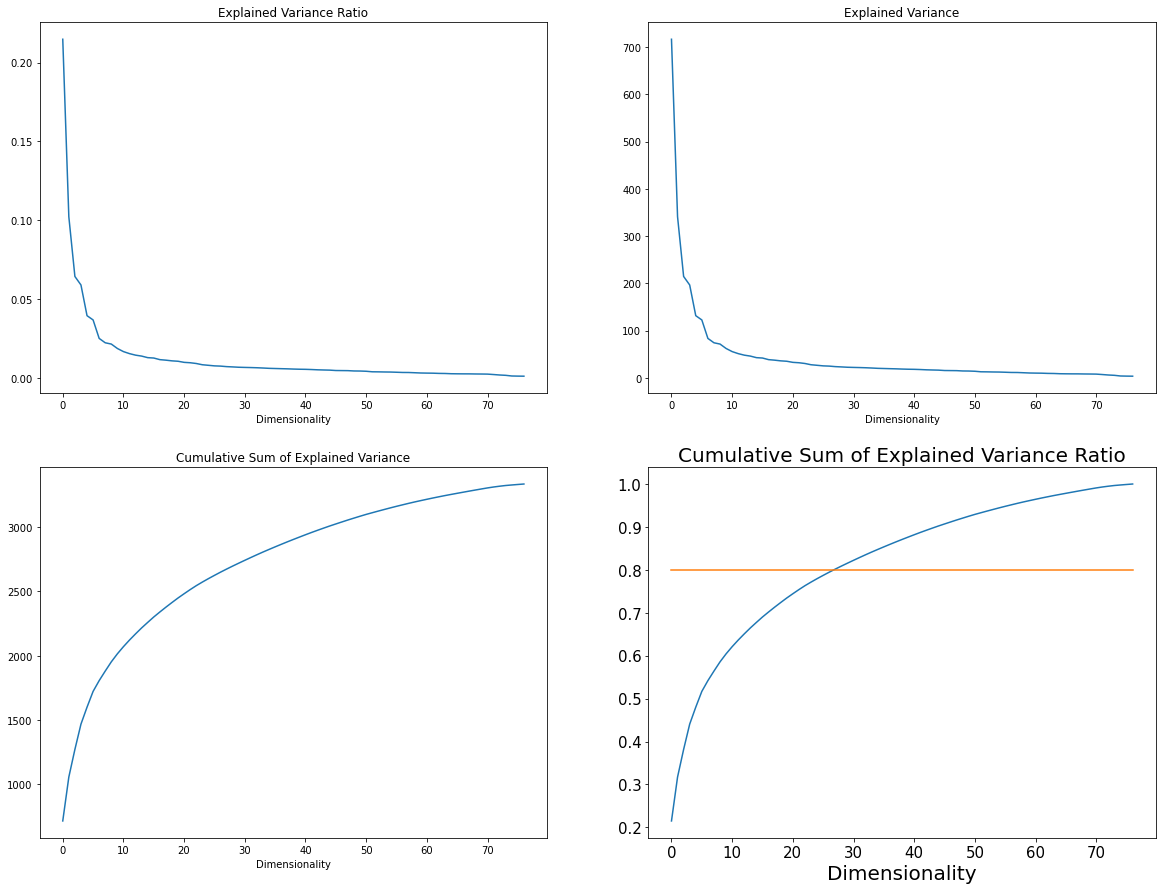

In [205]:
""" from inspection of graphs for explained variance, we can deduce approx what dimensionality
suffices to explain most of the variance, i.e. threshold after which eigenvalues of cov matrix 
in pca are negligible, i.e. a suitable low dimensionality to reduce dataset to """

fig, ax = plt.subplots(figsize = (20, 15), nrows=2, ncols = 2)
ax[0, 0].plot(pca_out.explained_variance_ratio_) #percentage of explained variance 
ax[0, 0].set_title ("Explained Variance Ratio")
ax[0, 0].set_xlabel("Dimensionality")
ax[0, 1].plot(pca_out.explained_variance_) #variance, eigenvalues of covariance matrix 
ax[0, 1].set_title ("Explained Variance")
ax[0, 1].set_xlabel("Dimensionality")
ax[1, 0].plot(np.cumsum(pca_out.explained_variance_))
ax[1, 0].set_title ("Cumulative Sum of Explained Variance")
ax[1, 0].set_xlabel("Dimensionality")
line1=np.cumsum(pca_out.explained_variance_ratio_)
x=np.arange(0, 77)
y=np.ones(77)*0.8
ax[1, 1].plot(line1)
ax[1, 1].set_title ("Cumulative Sum of Explained Variance Ratio", fontsize=20)
ax[1, 1].set_xlabel("Dimensionality", fontsize=20)
#ax[1, 1].axhline(y=0.8, color='r')
#ax[1, 1].plot(line2)
ax[1, 1].plot(x,y)
plt.savefig('pca.jpeg') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
""" here at dimensionality=30 approx 80% of variance is explained - reduce to PCA(30) """

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.1, '1.1')])

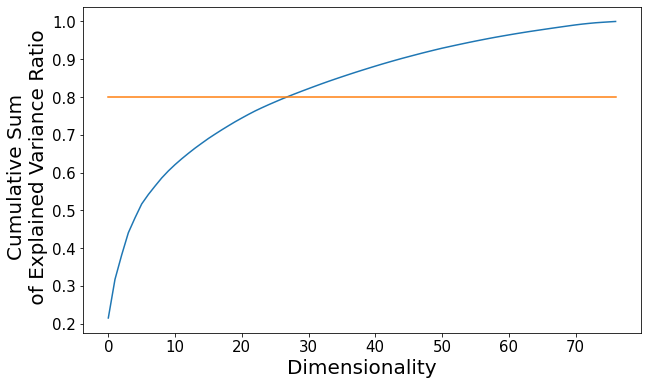

In [207]:
# isolating plots for the Cumulative Sum of Explained Variance Ratio

fig, ax = plt.subplots(figsize = (10, 6), nrows=1, ncols=1)
line1=np.cumsum(pca_out.explained_variance_ratio_)
x=np.arange(0, 77)
y=np.ones(77)*0.8
plt.plot(line1)
plt.ylabel("Cumulative Sum  \n of Explained Variance Ratio", fontsize=20)
plt.xlabel("Dimensionality", fontsize=20)
#ax[1, 1].axhline(y=0.8, color='r')
#ax[1, 1].plot(line2)
#plt.ylim([0, 1])
plt.plot(x,y)
plt.savefig('pca.jpeg') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [153]:
data_reduced, pca_out= dim_reduce(data_4, PCA(30), "both_rates", "both_pca",return_model=True) 
data_reduced.both_pca[0].shape #1000 time bin -long , 30 latent signals 

(1288, 30)

In [154]:
data_4.both_rates.shape #not restricting to same time interval all trials are included 
data_reduced.both_pca.shape 

(741,)

# DECODING 

In [155]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, validation_curve
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import r2_score, make_scorer
import statistics

# Without Previous History

CV SCORES PRIOR TO DELAY ADJUSTMENT - LINEAR REGRESSION

In [156]:
all_spikes= concat_trials(data_reduced, "both_spikes")
all_pcs= concat_trials(data_reduced, "both_pca")
all_rates= concat_trials(data_reduced, "both_rates")
                         
all_pos=concat_trials(data_reduced, "pos")
all_vel=concat_trials(data_reduced, "vel")

DELAY ADJUSTMENT

In [157]:
# comment this out not to implement delay adjustment 

all_spikes=all_spikes[:-5, :]
all_rates=all_rates[:-5, :]
all_pcs=all_pcs[:-5, :]

all_pos=all_pos[5:, :]
all_vel=all_vel[5:,:]


In [158]:
# Restrict to first 100,000 samples 
all_spikes=all_spikes[:100000, :]
all_pcs=all_pcs[:100000, :]
all_rates=all_rates[:100000, :]
locs=all_pos[:100000, :]
vel=all_vel[:100000, :]

FIND OPTIMAL ALPHA FOR RIDGE 

In [159]:
from sklearn.metrics import r2_score, accuracy_score, make_scorer

In [160]:
# semedo_opt_alpha, ridge_alpha_range and fit_semedo_ridge taken from from pyaldata repository, Gallego's group

def semedo_opt_alpha(alpha_range, cv_scores):
    """
    Select the optimal alpha parameter for ridge regression based on
    cross-validated test scores.
    Select the simplest model with test performance within 1 SEM of the highest test performance.
    Parameters
    ----------
    alpha_range : array-like
        candidate alpha values
    cv_scores : array-like
        cross-validated test scores corresponding
        to the values in alpha_range
    Returns
    -------
    optimal alpha : float
    """
    means = [np.mean(sc) for sc in cv_scores]

    max_score = np.max(means)
    max_score_sem = scipy.stats.sem(cv_scores[np.argmax(means)])

    # see which elements are within 1 SEM of the max score
    mask = means > (max_score - max_score_sem)

    # sort in ascending order and take the largest alpha ~ simplest model
    return np.max(alpha_range[mask])

In [161]:
import numpy as np
import scipy.stats
from scipy.linalg import null_space, orth

import pyaldata
#import pysubspaces.utils

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

#from beneuro.reduced_rank import ReducedRankRegressor

import warnings

from tqdm.auto import tqdm


def ridge_alpha_range(X, dmax_scales, z_score=False):
    """
    Determine the appropriate range for the ridge regularization parameter alpha based on the source data X
    Parameters
    ----------
    X : xr.DataArray
        source activities in ridge regression
    dmax_scales : array of floats
        list of scaling factors for the largest eigenvalue
        e.g. np.linspace(0.5, 1, n_alphas)
    z_score : bool, default False
        divide by the standard deviation of the activities or not
    Returns
    -------
    alpha_range : np.ndarray
        list of alpha values to try when doing cross-validation
    """
    dmax_scales = np.array(dmax_scales)

    if z_score:
        Z = pyaldata.z_score(X)
    else:
        Z = pyaldata.center(X)

    dmax = np.max(np.linalg.eigvals(Z.T @ Z))
    alpha_range = dmax * (1 - dmax_scales) / dmax_scales

    return alpha_range

In [162]:
def fit_semedo_ridge(X, y, n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True)):
    """
    Fit a ridge regression model by first finding the range of alpha values based on the input data,
    then select the best regressor using the method outlined in Semedo et al 2019
    Parameters
    ----------
    X : 2D np.array
        input data
        shape: n_samples x n_features
    y : np.array
        target values
    n_alpha : int, optional, default 100
        number of alpha values to try
    selection : str
        method to select the final alpha
        'semedo' or 'naive'
    cv : int or KFold
        cross-validation option to pass to cross_val_score
    Returns
    -------
    ridge : sklearn.linear_model.Ridge
        regressor fitted to X and y using the optimal alpha value
    """
    candidate_alphas = ridge_alpha_range(X, np.linspace(0.5, 1., n_alpha))
    candidate_alphas = np.real(candidate_alphas)
    default_scorer = make_scorer(r2_score, multioutput = 'variance_weighted')
    cv_scores = [cross_val_score(Ridge(alpha), X, y, cv = cv, scoring=default_scorer)
                 for alpha in tqdm(candidate_alphas)]
    if selection == 'semedo':
        opt_alpha = np.real(semedo_opt_alpha(candidate_alphas, cv_scores))
    else:
        opt_alpha = np.real(naive_opt_alpha(candidate_alphas, cv_scores))
    
    return Ridge(opt_alpha).fit(X, y)

In [163]:
# varying first and second input arguments to test for different input fields and predicted variables 

regressor=fit_semedo_ridge(all_pcs,  locs[:, 1], n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True))
regressor 
#      using smoothed rates as input 
#Ridge(alpha=0.0) [[[ all_rates, locs[:, 0] ]]]
#Ridge(alpha=0.0) [[[ all_rates, locs[:, 1] ]]]
#Ridge(alpha=0.0) [[[ all_rates, vel ]]]

#      using pcs as input 
#Ridge(alpha=347045.7664974565) [[[ all_pcs, locs[:, 0] ]]]
#Ridge(alpha=347045.7664974565) [[[ all_pcs, locs[:, 1] ]]]
#Ridge(alpha=347045.7664974565) [[[ all_pcs, vel ]]]


  0%|          | 0/100 [00:00<?, ?it/s]

Ridge(alpha=347043.97969542607)

In [164]:
# CALCULATING THE CV SCORES FOR LINEAR REGRESSION 
# using spikes 
cv_spikes_velx = cross_val_score(LinearRegression(), all_spikes, vel[:, 0], cv = KFold(10, shuffle=True))
cv_spikes_vely = cross_val_score(LinearRegression(), all_spikes, vel[:, 1], cv = KFold(10, shuffle=True))
cv_spikes_posx = cross_val_score(LinearRegression(), all_spikes, locs[:, 0], cv = KFold(10, shuffle=True))
cv_spikes_posy = cross_val_score(LinearRegression(), all_spikes, locs[:, 0], cv = KFold(10, shuffle=True))
# using smoothed rates 
cv_rates_velx = cross_val_score(LinearRegression(), all_rates, vel[:, 0], cv = KFold(10, shuffle=True))
cv_rates_vely = cross_val_score(LinearRegression(), all_rates, vel[:, 0], cv = KFold(10, shuffle=True))
cv_rates_posx = cross_val_score(LinearRegression(), all_rates, locs[:, 0], cv = KFold(10, shuffle=True))
cv_rates_posy = cross_val_score(LinearRegression(), all_rates, locs[:, 1], cv = KFold(10, shuffle=True))
# using latents found by PCA 
cv_pcs_velx = cross_val_score(LinearRegression(), all_pcs, vel[:, 0], cv = KFold(10, shuffle=True))
cv_pcs_vely = cross_val_score(LinearRegression(), all_pcs, vel[:, 1], cv = KFold(10, shuffle=True))
cv_pcs_posx = cross_val_score(LinearRegression(), all_pcs, locs[:, 0], cv = KFold(10, shuffle=True))
cv_pcs_posy = cross_val_score(LinearRegression(), all_pcs, locs[:, 1], cv = KFold(10, shuffle=True))

# CALCULATING THE CV SCORES FOR RIDGE REGRESSION 
# using optimal alphas it would be alpha=0.0 so Linear Regression 
# using spikes 
cv_spikes_velx_r = cross_val_score(Ridge(alpha=1e-5), all_spikes, vel[:, 0], cv = KFold(10, shuffle=True))
cv_spikes_vely_r = cross_val_score(Ridge(alpha=1e-5), all_spikes, vel[:, 1], cv = KFold(10, shuffle=True))
cv_spikes_posx_r = cross_val_score(Ridge(alpha=1e-5), all_spikes, locs[:,0], cv = KFold(10, shuffle=True))
cv_spikes_posy_r = cross_val_score(Ridge(alpha=1e-5), all_spikes, locs[:,1], cv = KFold(10, shuffle=True))
# using smoothed rates
cv_rates_velx_r = cross_val_score(Ridge(alpha=0), all_rates, vel[:, 0], cv = KFold(10, shuffle=True))
cv_rates_vely_r = cross_val_score(Ridge(alpha=0), all_rates, vel[:, 1], cv = KFold(10, shuffle=True))
cv_rates_posx_r = cross_val_score(Ridge(alpha=0), all_rates, locs[:, 0], cv = KFold(10, shuffle=True))
cv_rates_posy_r = cross_val_score(Ridge(alpha=0), all_rates, locs[:, 1], cv = KFold(10, shuffle=True))
# using latents found by PCA
cv_pcs_velx_r = cross_val_score(Ridge(alpha=347045.77), all_pcs, vel[:, 0], cv = KFold(10, shuffle=True))
cv_pcs_vely_r = cross_val_score(Ridge(alpha=347045.77), all_pcs, vel[:, 1], cv = KFold(10, shuffle=True))
cv_pcs_posx_r = cross_val_score(Ridge(alpha=347045.77), all_pcs, locs[:, 0], cv = KFold(10, shuffle=True))
cv_pcs_posy_r = cross_val_score(Ridge(alpha=347045.77), all_pcs, locs[:, 1], cv = KFold(10, shuffle=True))

In [165]:
# creating a dataframe for all scores
d = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'spikes-velx, LR': cv_spikes_velx ,
     'spikes-vely, LR': cv_spikes_vely ,
     'spikes-posx, LR': cv_spikes_posx ,
     'spikes-posy, LR': cv_spikes_posy ,
     'rates-velx, LR': cv_rates_velx ,
     'rates-vely, LR': cv_rates_vely ,
     'rates-posx, LR': cv_rates_posx , 
     'rates-posy, LR': cv_rates_posy ,
     'pcs-velx, LR': cv_pcs_velx,
     'pcs-vely, LR': cv_pcs_vely,
     'pcs-posx, LR': cv_pcs_posx, 
     'pcs-posy, LR': cv_pcs_posy, 
     'spikes-velx, RDG': cv_spikes_velx_r ,
     'spikes-vely, RDG': cv_spikes_vely_r ,
     'spikes-posx, RDG': cv_spikes_posx_r ,
     'spikes-posy, RDG': cv_spikes_posy_r ,
     'rates-velx, RDG': cv_rates_velx_r ,
     'rates-vely, RDG': cv_rates_vely_r ,
     'rates-posx, RDG': cv_rates_posx_r , 
     'rates-posy, RDG': cv_rates_posy_r , 
     'pcs-velx, RDG': cv_pcs_velx_r,
     'pcs-vely, RDG': cv_pcs_vely_r,
     'pcs-posx, RDG': cv_pcs_posx_r, 
     'pcs-posy, RDG': cv_pcs_posy_r
    }
pd.set_option('display.max_columns', None)
cv_scores = pd.DataFrame(data=d)
#cv_scores

In [166]:
""" fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['pcs-posx, LR', 'rates-posx, LR', 'pcs-posx, RDG', 'rates-posx, RDG'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Horizontal Position') """

" fig, ax = plt.subplots(figsize = (10, 5))\nboxplot_pos = cv_scores.boxplot(column=['pcs-posx, LR', 'rates-posx, LR', 'pcs-posx, RDG', 'rates-posx, RDG'])  \nboxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Horizontal Position') "

In [167]:
""" fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['pcs-posy, LR', 'rates-posy, LR', 'pcs-posy, RDG', 'rates-posy, RDG'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Vertical Position') """

" fig, ax = plt.subplots(figsize = (10, 5))\nboxplot_pos = cv_scores.boxplot(column=['pcs-posy, LR', 'rates-posy, LR', 'pcs-posy, RDG', 'rates-posy, RDG'])  \nboxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Vertical Position') "

In [168]:
""" fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['pcs-velx, LR', 'rates-velx, LR', 'pcs-velx, RDG', 'rates-velx, RDG'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity in x') """

" fig, ax = plt.subplots(figsize = (10, 5))\nboxplot_pos = cv_scores.boxplot(column=['pcs-velx, LR', 'rates-velx, LR', 'pcs-velx, RDG', 'rates-velx, RDG'])  \nboxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity in x') "

In [169]:
""" fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['pcs-vely, LR', 'rates-vely, LR', 'pcs-vely, RDG', 'rates-vely, RDG'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity in y')"""

" fig, ax = plt.subplots(figsize = (10, 5))\nboxplot_pos = cv_scores.boxplot(column=['pcs-vely, LR', 'rates-vely, LR', 'pcs-vely, RDG', 'rates-vely, RDG'])  \nboxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity in y')"

In [170]:
# creating a dataframe for the average scores, for linear and ridge regression using latents by PCA or rates
f = {'CV':['AVERAGE SCORE' ], 
     'X-velx, LR': [np.mean(cv_pcs_velx)] ,
     'X-vely, LR': [np.mean(cv_pcs_vely)] ,
     'F-velx, LR': [np.mean(cv_rates_velx)] ,
     'F-vely, LR': [np.mean(cv_rates_vely)] ,
     'X-posx, LR': [np.mean(cv_pcs_posx)] ,
     'X-posy, LR': [np.mean(cv_pcs_posy)] ,
     'F-posx, LR': [np.mean(cv_rates_posx)] , 
     'F-posy, LR': [np.mean(cv_rates_posy)] , 
     'X-velx, Ridge': [np.mean(cv_pcs_velx_r)],
     'X-vely, Ridge': [np.mean(cv_pcs_vely_r)],
     'F-velx, Ridge': [np.mean(cv_rates_velx_r)],  
     'F-vely, Ridge': [np.mean(cv_rates_vely_r)],  
     'X-posx, Ridge': [np.mean(cv_pcs_posx_r)],
     'X-posy, Ridge': [np.mean(cv_pcs_posy_r)],
     'F-posx, Ridge': [np.mean(cv_rates_posx_r)], 
     'F-posy, Ridge': [np.mean(cv_rates_posy_r)]
    }
pd.set_option('display.max_columns', None)
cv_scores_mean = pd.DataFrame(data=f)
cv_scores_mean

CV  X-velx, LR  X-vely, LR  F-velx, LR  F-vely, LR  X-posx, LR  \
0  AVERAGE SCORE    0.466344    0.548093    0.521437    0.521443    0.396512   

   X-posy, LR  F-posx, LR  F-posy, LR  X-velx, Ridge  X-vely, Ridge  \
0    0.495063    0.472805    0.530664       0.464692        0.54743   

   F-velx, Ridge  F-vely, Ridge  X-posx, Ridge  X-posy, Ridge  F-posx, Ridge  \
0       0.521295       0.583077       0.395021       0.493713       0.472926   

   F-posy, Ridge  
0       0.530783

In [171]:
# dataframe WITHOUT HISTORY USING LINEAR REGRESSION for rates
final_rates = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_rates_velx ,
     'Vel_y': cv_rates_vely ,
     'Pos_x': cv_rates_posx ,
     'Pos_y': cv_rates_posy 
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_rates = pd.DataFrame(data=final_rates)
#cv_scores_lr_rates

In [172]:
# dataframe WITHOUT HISTORY USING LINEAR REGRESSION for rates
final_latents = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_pcs_velx,
     'Vel_y': cv_pcs_vely,
     'Pos_x': cv_pcs_posx, 
     'Pos_y': cv_pcs_posy
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_latents = pd.DataFrame(data=final_latents)
#cv_scores_lr_latents

In [173]:
""" fig, ax = plt.subplots(figsize = (8, 4))
boxplot_final_rates = cv_scores_lr_rates.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'])  
boxplot_final_rates.set_title('10-fold CV, scores - Linear Regression, using Firing Rates as an Input', fontsize=13)
boxplot_final_rates.set_ylim([0.37, 0.56])
boxplot_final_rates.set_xlabel('Output Field',fontsize=13 )
plt.savefig('LR_scores_rates.jpeg') """


" fig, ax = plt.subplots(figsize = (8, 4))\nboxplot_final_rates = cv_scores_lr_rates.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'])  \nboxplot_final_rates.set_title('10-fold CV, scores - Linear Regression, using Firing Rates as an Input', fontsize=13)\nboxplot_final_rates.set_ylim([0.37, 0.56])\nboxplot_final_rates.set_xlabel('Output Field',fontsize=13 )\nplt.savefig('LR_scores_rates.jpeg') "

In [174]:
""" fig, ax = plt.subplots(figsize = (8, 4))
boxplot_final_pcs = cv_scores_lr_latents.boxplot(column=[ 'Vel_x','Vel_y', 'Pos_x',  'Pos_y'])  
boxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, using PCs as an Input', fontsize=13)
boxplot_final_pcs.set_ylim([0.37, 0.56])
boxplot_final_pcs.set_xlabel('Output Field',fontsize=13 )
plt.savefig('LR_scores_pcs.jpeg') """


" fig, ax = plt.subplots(figsize = (8, 4))\nboxplot_final_pcs = cv_scores_lr_latents.boxplot(column=[ 'Vel_x','Vel_y', 'Pos_x',  'Pos_y'])  \nboxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, using PCs as an Input', fontsize=13)\nboxplot_final_pcs.set_ylim([0.37, 0.56])\nboxplot_final_pcs.set_xlabel('Output Field',fontsize=13 )\nplt.savefig('LR_scores_pcs.jpeg') "

# With Previous History

In [175]:
# BUILD HISTORY ON LATENTS  

bins_before=5

pcs_hist_matrix=[[]]
for t in range (bins_before+1, len(all_pcs)): 
    X_hist=[]
    X_hist.append(all_pcs[t, :])
    X_hist.append(all_pcs[t-1, :])
    X_hist.append(all_pcs[t-2, :])
    X_hist.append(all_pcs[t-3, :])
    X_hist.append(all_pcs[t-4, :])
    X_hist.append(all_pcs[t-5, :])
    X_hist=np.reshape(X_hist, (1,(bins_before+1)*30))
    pcs_hist_matrix.append(X_hist)
pcs_hist_matrix.pop(0)
len(pcs_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
pcs_hist_matrix=np.squeeze(pcs_hist_matrix)
pcs_hist_matrix=np.array(pcs_hist_matrix)
pcs_hist_matrix.shape #(99994, 180)

(99994, 180)

In [176]:
pos_for_history=[[]]
pos_row=locs[6:,:]
pos_for_history.append(pos_row)
pos_for_history.pop(0)
len(pos_for_history) #1
#len(np.transpose(pos_for_history)) #2
locs_hist=pos_for_history[0][:, :]
locs_hist.shape #(99990, 2)

type(locs_hist)
locs_hist.shape

vel_for_history=[[]]
vel_row=vel[6:,:]
vel_for_history.append(vel_row)
vel_for_history.pop(0)
len(vel_for_history) #1
#len(np.transpose(pos_for_history)) #2
vel_hist=vel_for_history[0][:, :]
vel_hist.shape #(99990, 2)

type(vel_hist)
vel_hist.shape

(99994, 2)

In [177]:
# RIDGE OPTIMISATION 

regressor=fit_semedo_ridge(pcs_hist_matrix,  vel_hist, n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True))
regressor 
#      using pcs with history as input 
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, locs_hist[:, 0] ]]]
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, locs_hist[:, 1] ]]]
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, vel_hist ]]]


  0%|          | 0/100 [00:00<?, ?it/s]

Ridge(alpha=0.0)

In [178]:
# CV SCORES FOR LINEAR REGRESSION WITH HISTORY using the latents found by PCA
# Linear
cv_scores_X_hist_velx = cross_val_score(LinearRegression(), pcs_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_vely = cross_val_score(LinearRegression(), pcs_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posx = cross_val_score(LinearRegression(), pcs_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posy = cross_val_score(LinearRegression(), pcs_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))
# Ridge 
cv_scores_X_hist_velx_r = cross_val_score(Ridge(alpha=0.0), pcs_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_vely_r = cross_val_score(Ridge(alpha=0.0), pcs_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posx_r = cross_val_score(Ridge(alpha=0.0), pcs_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posy_r = cross_val_score(Ridge(alpha=0.0), pcs_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))

In [179]:
# dataframe for linear and ridge regression based on the latents found by PCA
# cv scores
f = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'X-velx, LR': cv_scores_X_hist_velx ,
     'X-vely, LR': cv_scores_X_hist_vely ,
     'X-posx, LR': cv_scores_X_hist_posx ,
     'X-posy, LR': cv_scores_X_hist_posy ,
     'X-velx, Ridge': cv_scores_X_hist_velx_r,
     'X-vely, Ridge': cv_scores_X_hist_vely_r,
     'X-posx, Ridge': cv_scores_X_hist_posx_r,
     'X-posy, Ridge': cv_scores_X_hist_posy_r 
    }
pd.set_option('display.max_columns', None)
cv_scores_hist = pd.DataFrame(data=f)
cv_scores_hist

K  X-velx, LR  X-vely, LR  X-posx, LR  X-posy, LR  X-velx, Ridge  \
0   1    0.554436    0.606528    0.438394    0.544307       0.569013   
1   2    0.547891    0.621733    0.456299    0.549338       0.540303   
2   3    0.552584    0.603516    0.447252    0.545491       0.560547   
3   4    0.550069    0.616152    0.449256    0.544463       0.549054   
4   5    0.549008    0.611777    0.444205    0.555532       0.546764   
5   6    0.555740    0.615562    0.439656    0.550660       0.546994   
6   7    0.560503    0.601028    0.435520    0.548687       0.552953   
7   8    0.565090    0.617385    0.427682    0.525387       0.556110   
8   9    0.558545    0.620451    0.440515    0.543183       0.552096   
9  10    0.554893    0.605664    0.433689    0.531798       0.573731   

   X-vely, Ridge  X-posx, Ridge  X-posy, Ridge  
0       0.613758       0.454827       0.543092  
1       0.609659       0.445870       0.541750  
2       0.613119       0.447318       0.542723  
3       0.622096       0.431309       0.548390  
4       0.603750       0.427311       0.539852  
5       0.612595       0.442539       0.543061  
6       0.605391       0.429281       0.549533  
7       0.617831       0.443740       0.537754  
8       0.609655       0.451929       0.553877  
9       0.612465       0.435102       0.541901

In [180]:
# dataframe for linear and ridge regression based on the smoothed rates 
# average cv scores
f = {'CV':['AVERAGE SCORE' ], 
     'X-velx, LR': [np.mean(cv_scores_X_hist_velx)] ,
     'X-vely, LR': [np.mean(cv_scores_X_hist_vely)] ,
     'X-posx, LR': [np.mean(cv_scores_X_hist_posx)] ,
     'X-posy, LR': [np.mean(cv_scores_X_hist_posy)] ,
     'X-velx, Ridge': [np.mean(cv_scores_X_hist_velx_r)],
     'X-vely, Ridge': [np.mean(cv_scores_X_hist_vely_r)],
     'X-posx, Ridge': [np.mean(cv_scores_X_hist_posx_r)],
     'X-posy, Ridge': [np.mean(cv_scores_X_hist_posy_r)]
    }
pd.set_option('display.max_columns', None)
cv_scores_hist_mean = pd.DataFrame(data=f)
cv_scores_hist_mean

CV  X-velx, LR  X-vely, LR  X-posx, LR  X-posy, LR  \
0  AVERAGE SCORE    0.554876     0.61198    0.441247    0.543885   

   X-velx, Ridge  X-vely, Ridge  X-posx, Ridge  X-posy, Ridge  
0       0.554757       0.612032       0.440923       0.544193

In [181]:
""" fig, ax = plt.subplots(figsize = (15, 5))
boxplot = cv_scores_hist.boxplot(column=['X-velx, LR', 'X-vely, LR', 'X-velx, Ridge', 'X-vely, Ridge', 'X-posx, LR', 'X-posx, Ridge', 'X-posy, LR', 'X-posy, Ridge'])  
boxplot.set_title('10-fold CV, scores - Linear and Ridge Regression, Using Latents With History') """

" fig, ax = plt.subplots(figsize = (15, 5))\nboxplot = cv_scores_hist.boxplot(column=['X-velx, LR', 'X-vely, LR', 'X-velx, Ridge', 'X-vely, Ridge', 'X-posx, LR', 'X-posx, Ridge', 'X-posy, LR', 'X-posy, Ridge'])  \nboxplot.set_title('10-fold CV, scores - Linear and Ridge Regression, Using Latents With History') "

In [182]:
# BUILD HISTORY ON RATES 

bins_before=5

rates_hist_matrix=[[]]
for t in range (bins_before+1, len(all_rates)): 
    X_hist=[]
    X_hist.append(all_rates[t, :])
    X_hist.append(all_rates[t-1, :])
    X_hist.append(all_rates[t-2, :])
    X_hist.append(all_rates[t-3, :])
    X_hist.append(all_rates[t-4, :])
    X_hist.append(all_rates[t-5, :])
    X_hist=np.reshape(X_hist, (1,(bins_before+1)*77))
    rates_hist_matrix.append(X_hist)
rates_hist_matrix.pop(0)
len(rates_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
rates_hist_matrix=np.squeeze(rates_hist_matrix)
rates_hist_matrix=np.array(rates_hist_matrix)
rates_hist_matrix.shape #(99994, 180)

(99994, 462)

In [61]:
# RIDGE OPTIMISATION

regressor=fit_semedo_ridge(rates_hist_matrix,  locs_hist[:, 1], n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True))
regressor 
#      using rates with history as input 
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, locs_hist[:, 0] ]]]
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, locs_hist[:, 1] ]]]
#Ridge(alpha=0.0) [[[ pcs_hist_matrix, vel_hist ]]]

  0%|          | 0/100 [00:00<?, ?it/s]

Ridge(alpha=0.0)

In [183]:
# CV SCORES FOR LINEAR & Ridge REGRESSION WITH HISTORY using the smoothed rates

# Linear 
cv_scores_F_hist_velx = cross_val_score(LinearRegression(), rates_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_vely = cross_val_score(LinearRegression(), rates_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posx = cross_val_score(LinearRegression(), rates_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posy = cross_val_score(LinearRegression(), rates_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))
# Ridge
cv_scores_F_hist_velx_r = cross_val_score(Ridge(alpha=0.0), rates_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_vely_r = cross_val_score(Ridge(alpha=0.0), rates_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posx_r = cross_val_score(Ridge(alpha=0.0), rates_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posy_r = cross_val_score(Ridge(alpha=0.0), rates_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))

In [184]:
f = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'F-velx, LR': cv_scores_F_hist_velx ,
     'F-vely, LR': cv_scores_F_hist_vely ,
     'F-posx, LR': cv_scores_F_hist_posx ,
     'F-posy, LR': cv_scores_F_hist_posy ,
     'F-velx, Ridge': cv_scores_F_hist_velx_r,
     'F-vely, Ridge': cv_scores_F_hist_vely_r,
     'F-posx, Ridge': cv_scores_F_hist_posx_r,
     'F-posy, Ridge': cv_scores_F_hist_posy_r 
    }
pd.set_option('display.max_columns', None)
cv_scores_hist = pd.DataFrame(data=f)
#cv_scores_hist

In [185]:
f = {'CV':['AVERAGE SCORE' ], 
     'F-velx, LR': [np.mean(cv_scores_F_hist_velx)] ,
     'F-vely, LR': [np.mean(cv_scores_F_hist_vely)] ,
     'F-posx, LR': [np.mean(cv_scores_F_hist_posx)] ,
     'F-posy, LR': [np.mean(cv_scores_F_hist_posy)] ,
     'F-velx, Ridge': [np.mean(cv_scores_F_hist_velx_r)],
     'F-vely, Ridge': [np.mean(cv_scores_F_hist_vely_r)],
     'F-posx, Ridge': [np.mean(cv_scores_F_hist_posx_r)],
     'F-posy, Ridge': [np.mean(cv_scores_F_hist_posy_r)]
    }
pd.set_option('display.max_columns', None)
cv_scores_hist_mean = pd.DataFrame(data=f)
cv_scores_hist_mean

CV  F-velx, LR  F-vely, LR  F-posx, LR  F-posy, LR  \
0  AVERAGE SCORE    0.607104    0.641244    0.513878    0.576365   

   F-velx, Ridge  F-vely, Ridge  F-posx, Ridge  F-posy, Ridge  
0       0.607074        0.64133       0.513208       0.576183

In [186]:
""" fig, ax = plt.subplots(figsize = (15, 5))
boxplot = cv_scores_hist.boxplot(column=['F-velx, LR', 'F-velx, Ridge','F-vely, LR', 'F-vely, Ridge','F-posx, LR', 'F-posx, Ridge', 'F-posy, LR', 'F-posy, Ridge'])  
boxplot.set_title('10-fold CV, scores - Linear and Ridge Regression, Using Latents With History') """

" fig, ax = plt.subplots(figsize = (15, 5))\nboxplot = cv_scores_hist.boxplot(column=['F-velx, LR', 'F-velx, Ridge','F-vely, LR', 'F-vely, Ridge','F-posx, LR', 'F-posx, Ridge', 'F-posy, LR', 'F-posy, Ridge'])  \nboxplot.set_title('10-fold CV, scores - Linear and Ridge Regression, Using Latents With History') "

In [187]:
# OVERALL SHOWING THAT RIDGE DOES NOT ENHANCE PERFORMANCE 
overall = {'CV':['AVERAGE SCORE' ], 
     'X-velx, LR': [np.mean(cv_scores_X_hist_velx)] ,
     'F-velx, LR': [np.mean(cv_scores_F_hist_velx)] ,
     'X-vely, LR': [np.mean(cv_scores_X_hist_vely)] ,
     'F-vely, LR': [np.mean(cv_scores_F_hist_vely)] ,
     'X-posx, LR': [np.mean(cv_scores_X_hist_posx)] ,
     'F-posx, LR': [np.mean(cv_scores_F_hist_posx)] ,
     'X-posy, LR': [np.mean(cv_scores_X_hist_posy)] ,
     'F-posy, LR': [np.mean(cv_scores_F_hist_posy)] ,
     'X-velx, Ridge': [np.mean(cv_scores_X_hist_velx_r)],
     'F-velx, Ridge': [np.mean(cv_scores_F_hist_velx_r)],
     'X-vely, Ridge': [np.mean(cv_scores_X_hist_vely_r)],
     'F-vely, Ridge': [np.mean(cv_scores_F_hist_vely_r)],
     'X-posx, Ridge': [np.mean(cv_scores_X_hist_posx_r)],
     'F-posx, Ridge': [np.mean(cv_scores_F_hist_posx_r)],
     'X-posy, Ridge': [np.mean(cv_scores_X_hist_posy_r)], 
     'F-posy, Ridge': [np.mean(cv_scores_F_hist_posy_r)]
    }
pd.set_option('display.max_columns', None)
cv_scores_hist_mean = pd.DataFrame(data=overall)
cv_scores_hist_mean

CV  X-velx, LR  F-velx, LR  X-vely, LR  F-vely, LR  X-posx, LR  \
0  AVERAGE SCORE    0.554876    0.607104     0.61198    0.641244    0.441247   

   F-posx, LR  X-posy, LR  F-posy, LR  X-velx, Ridge  F-velx, Ridge  \
0    0.513878    0.543885    0.576365       0.554757       0.607074   

   X-vely, Ridge  F-vely, Ridge  X-posx, Ridge  F-posx, Ridge  X-posy, Ridge  \
0       0.612032        0.64133       0.440923       0.513208       0.544193   

   F-posy, Ridge  
0       0.576183

In [188]:
# WITH HISTORY USING LINEAR REGRESSION 
final_hist_rates = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_F_hist_velx,
     'Vel_y': cv_scores_F_hist_vely,
     'Pos_x': cv_scores_F_hist_posx ,
     'Pos_y': cv_scores_F_hist_posy
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_hist_rates = pd.DataFrame(data=final_hist_rates)
# cv_scores_lr_hist_rates

In [189]:
# WITH HISTORY USING LINEAR REGRESSION 
final_hist_latents = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_X_hist_velx,
     'Vel_y': cv_scores_X_hist_vely,
     'Pos_x': cv_scores_X_hist_posx, 
     'Pos_y': cv_scores_X_hist_posy
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_hist_pcs = pd.DataFrame(data=final_hist_latents)
# cv_scores_lr_hist_pcs

In [190]:
""" fig, ax = plt.subplots(figsize = (8, 4))
boxplot_final_rates = cv_scores_lr_hist_rates.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_final_rates.set_title('10-fold CV, scores - Linear Regression, using Firing Rates with History as an Input', fontsize=13)
boxplot_final_rates.set_ylim([0.40, 0.66])
boxplot_final_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('LR_scores_rates_hist.jpeg')""" 

" fig, ax = plt.subplots(figsize = (8, 4))\nboxplot_final_rates = cv_scores_lr_hist_rates.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_final_rates.set_title('10-fold CV, scores - Linear Regression, using Firing Rates with History as an Input', fontsize=13)\nboxplot_final_rates.set_ylim([0.40, 0.66])\nboxplot_final_rates.set_xlabel('Output Field', fontsize=13)\nplt.savefig('LR_scores_rates_hist.jpeg')"

In [191]:
""" fig, ax = plt.subplots(figsize = (8, 4))
boxplot_final_pcs = cv_scores_lr_hist_pcs.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, using PCs with History as an Input',fontsize=13 )
boxplot_final_pcs.set_ylim([0.40, 0.66])
boxplot_final_pcs.set_xlabel('Output Field', fontsize=13)
plt.savefig('LR_scores_pcs_hist.jpeg') """

" fig, ax = plt.subplots(figsize = (8, 4))\nboxplot_final_pcs = cv_scores_lr_hist_pcs.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, using PCs with History as an Input',fontsize=13 )\nboxplot_final_pcs.set_ylim([0.40, 0.66])\nboxplot_final_pcs.set_xlabel('Output Field', fontsize=13)\nplt.savefig('LR_scores_pcs_hist.jpeg') "

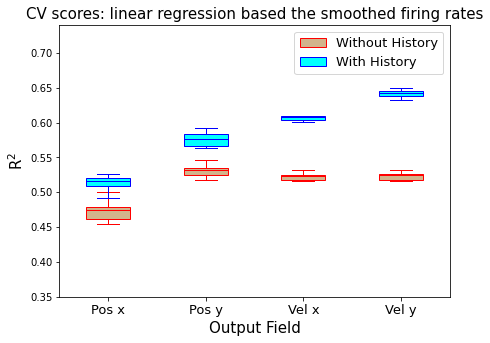

In [192]:
# BOXPLOT of CV SCORES for LINEAR REGRESSION based on the SMOOTHED RATES 
# COMPARING WITH vs WITHOUT HISTORY 

import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
cv_rates = [cv_rates_posx, cv_rates_posy, cv_rates_velx, cv_rates_vely]
cv_rates_hist = [cv_scores_F_hist_posx,cv_scores_F_hist_posy, cv_scores_F_hist_velx, cv_scores_F_hist_vely ]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates, 'red', 'tan')
bp2 = box_plot(cv_rates_hist, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Without History', 'With History'], fontsize=13)
ax.set_ylim(0.35, 0.74)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression based the smoothed firing rates', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LR_scores_smoothed_rates.jpeg')

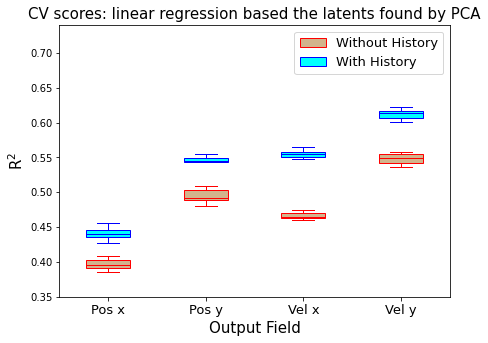

In [193]:
# BOXPLOT of CV SCORES for LINEAR REGRESSION based on the LATENTS FOUND by PCA
# COMPARING WITH vs WITHOUT HISTORY 

cv_pcs = [cv_pcs_posx, cv_pcs_posy, cv_pcs_velx, cv_pcs_vely]
cv_pcs_hist = [cv_scores_X_hist_posx,cv_scores_X_hist_posy, cv_scores_X_hist_velx, cv_scores_X_hist_vely ]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_pcs, 'red', 'tan')
bp2 = box_plot(cv_pcs_hist, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Without History', 'With History'], fontsize=13)
ax.set_ylim(0.35, 0.74)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression based the latents found by PCA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LR_scores_PCA.jpeg')

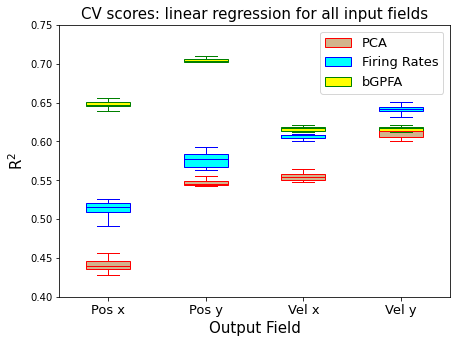

In [195]:
# IMPORTING FILES with the CV SCORES for LINEAR REGRESSION using bGPFA-inferred LATENTS

with open("file1.txt", 'r') as f:
    cv_scores_X_hist_posx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posx=[float(s) for s in cv_scores_X_hist_posx_b]
bGPFA_cv_scores_X_hist_posx

with open("file2.txt", 'r') as f:
    cv_scores_X_hist_posy_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posy=[float(s) for s in cv_scores_X_hist_posy_b]
bGPFA_cv_scores_X_hist_posy

with open("file3.txt", 'r') as f:
    cv_scores_X_hist_velx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_velx=[float(s) for s in cv_scores_X_hist_velx_b]
bGPFA_cv_scores_X_hist_velx

with open("file4.txt", 'r') as f:
    cv_scores_X_hist_vely_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_vely=[float(s) for s in cv_scores_X_hist_vely_b]

bGPFA_cv_scores_X_hist_vel=[]
bGPFA_cv_scores_X_hist_pos=[]
for i in range(0, 9): 
    a=(bGPFA_cv_scores_X_hist_velx[i]+bGPFA_cv_scores_X_hist_vely[i])/2
    b=(bGPFA_cv_scores_X_hist_posx[i]+bGPFA_cv_scores_X_hist_posy[i])/2
    bGPFA_cv_scores_X_hist_vel.append(a)
    bGPFA_cv_scores_X_hist_pos.append(b)
    
    
# COMPARATIVE BOXPLOT of CV SCORES for LINEAR REGRESSION 
# CROSS-COMPARISON AMONST 3 INPUT FIELDS FOR LINEAR REGRESSION 

cv_rates_hist = [cv_scores_F_hist_posx,cv_scores_F_hist_posy, cv_scores_F_hist_velx, cv_scores_F_hist_vely ]
cv_pcs_hist = [cv_scores_X_hist_posx,cv_scores_X_hist_posy, cv_scores_X_hist_velx, cv_scores_X_hist_vely ]
cv_bGPFA_hist = [bGPFA_cv_scores_X_hist_posx, bGPFA_cv_scores_X_hist_posy, bGPFA_cv_scores_X_hist_velx, bGPFA_cv_scores_X_hist_velx]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_pcs_hist, 'red', 'tan')
bp2 = box_plot(cv_rates_hist, 'blue', 'cyan')
bp3 = box_plot(cv_bGPFA_hist, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['PCA', 'Firing Rates', 'bGPFA'], fontsize=13)
ax.set_ylim(0.40, 0.75)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression for all input fields', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LR_COMPARISON_FIELDS_2.jpeg')

PREDICTING POSITION USING RATES & PCs WITH HISTORY

In [209]:
# training on 90% 
X_train_rates_lr=rates_hist_matrix[0:90000, :] 
X_train_pcs_lr=pcs_hist_matrix[0:90000, :]
y_train_lr=locs_hist[0:90000, :]
X_test_rates_lr=rates_hist_matrix[90000:, :]
X_test_pcs_lr=pcs_hist_matrix[90000:, :]
y_test_lr=locs_hist[90000:, :]

In [210]:
#rates
model_rates=LinearRegression()
model_rates.fit(X_train_rates_lr, y_train_lr)
y_predict_rates_lr=model_rates.predict(X_test_rates_lr)
#pcs
model_pcs=LinearRegression()
model_pcs.fit(X_train_pcs_lr, y_train_lr)
y_predict_pcs_lr=model_pcs.predict(X_test_pcs_lr)

Text(0.5, 1.0, 'Hand position in x for 25-30% testing data')

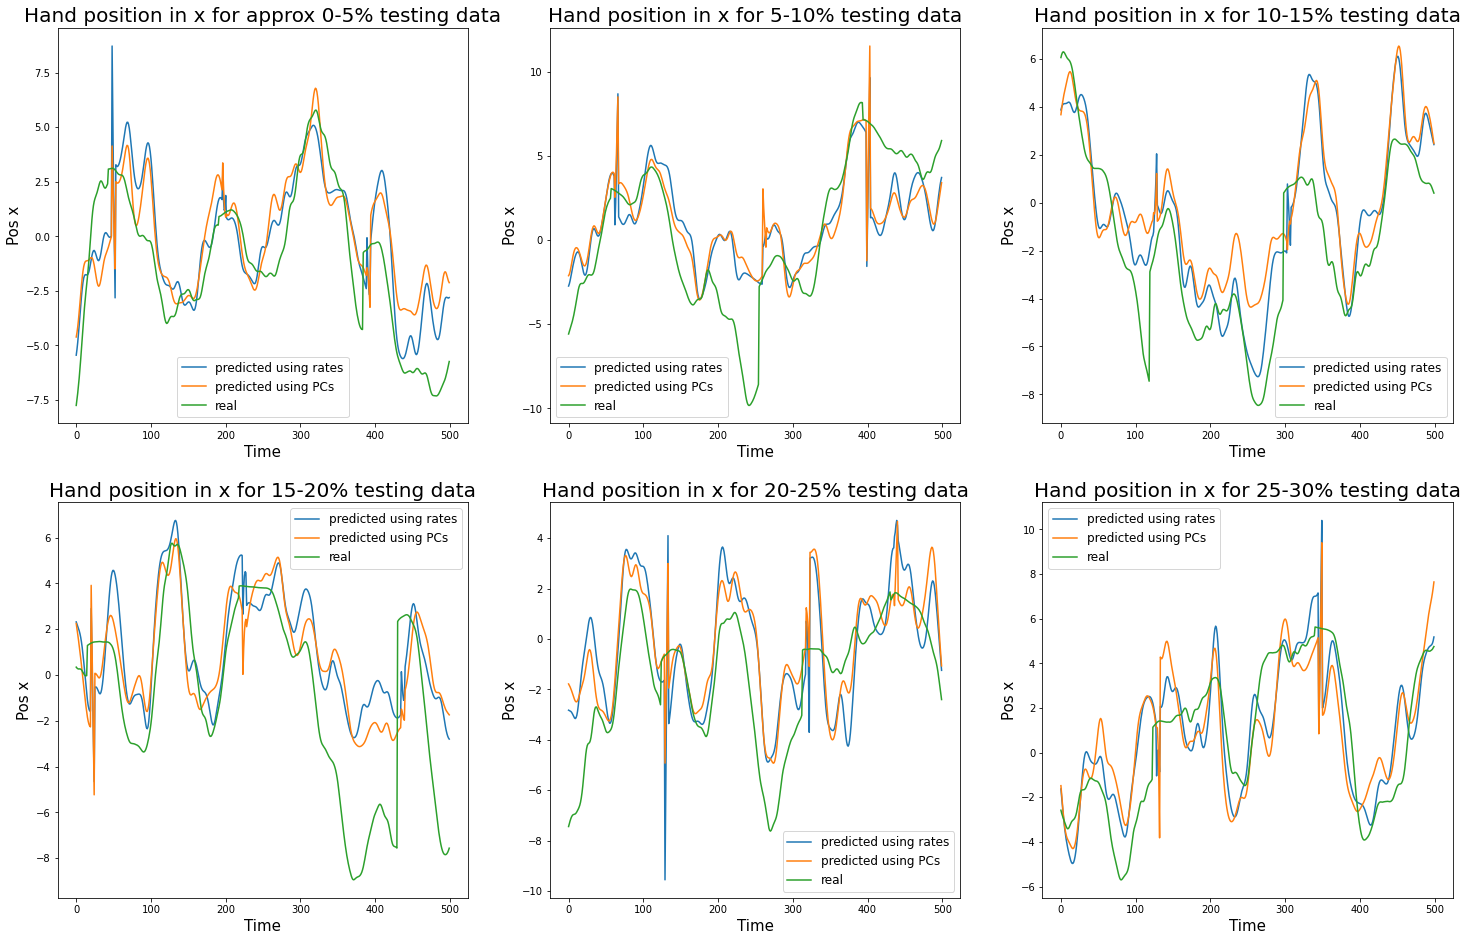

In [75]:
fig, ax = plt.subplots(figsize = (25, 16), nrows=2, ncols=3)
ax[0][0].plot(y_predict_rates_lr[0:500, 0]) 
ax[0][0].plot(y_predict_pcs_lr[0:500, 0]) 
ax[0][0].plot(y_test_lr[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_predict_rates_lr[500:1000, 0]) 
ax[0][1].plot(y_predict_pcs_lr[500:1000, 0]) 
ax[0][1].plot(y_test_lr[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_predict_rates_lr[1000:1500, 0]) 
ax[0][2].plot(y_predict_pcs_lr[1000:1500, 0]) 
ax[0][2].plot(y_test_lr[1000:1500, 0])
ax[0][2].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos x', fontsize=15)
ax[0][2].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_predict_rates_lr[1500:2000, 0]) 
ax[1][0].plot(y_predict_pcs_lr[1500:2000, 0]) 
ax[1][0].plot(y_test_lr[1500:2000, 0])
ax[1][0].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_predict_rates_lr[2000:2500, 0]) 
ax[1][1].plot(y_predict_pcs_lr[2000:2500, 0]) 
ax[1][1].plot(y_test_lr[2000:2500, 0])
ax[1][1].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_predict_rates_lr[2500:3000, 0]) 
ax[1][2].plot(y_predict_pcs_lr[2500:3000, 0]) 
ax[1][2].plot(y_test_lr[2500:3000, 0])
ax[1][2].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos x', fontsize=15)
ax[1][2].set_title('Hand position in x for 25-30% testing data', fontsize=20)

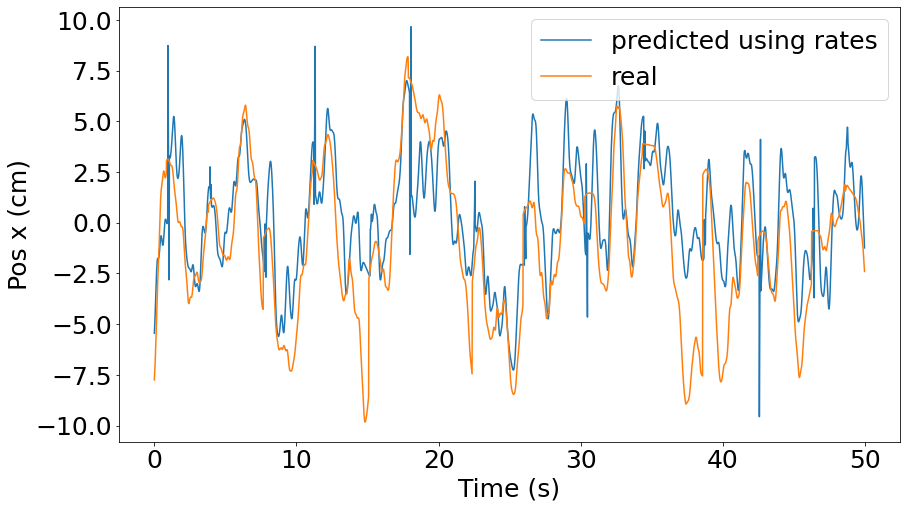

In [213]:
# real vs predicted hand trajectory in x - predicted by linear regression based on the smoothed rates

time=0.02*np.arange(len(y_test_lr[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_predict_rates_lr[0:2500, 0]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test_lr[0:2500, 0])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n linear regression based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_x_Rates.jpeg')

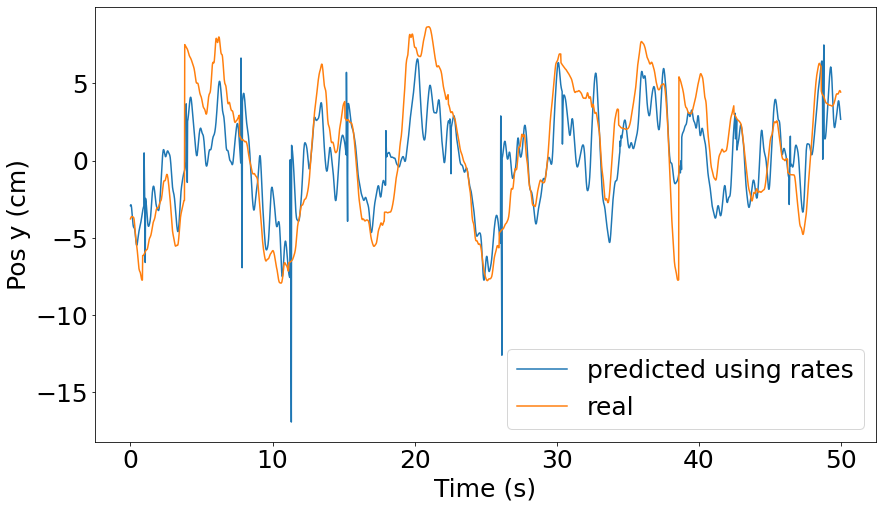

In [214]:
# real vs predicted hand trajectory in y - predicted by linear regression based on the smoothed rates

time=0.02*np.arange(len(y_test_lr[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_predict_rates_lr[0:2500, 1]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test_lr[0:2500, 1])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in y for 25% of testing data: \n linear regression based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_y_Rates.jpeg')

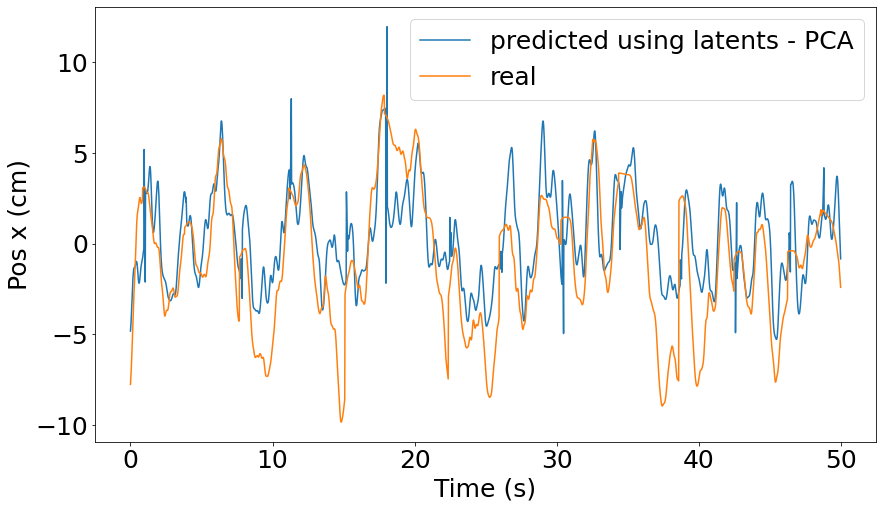

In [215]:
# real vs predicted hand trajectory in x - predicted by linear regression based on the latents found by PCA

time=0.02*np.arange(len(y_test_lr[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
# plt.plot(y_predict_rates_lr[0:2500, 0]) 
plt.plot(time, y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test_lr[0:2500, 0])
plt.legend(['predicted using latents - PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
#plt.title('Real & predicted hand position in x for 25% of testing data: \n linear regression based on latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_x_PCA.jpeg')

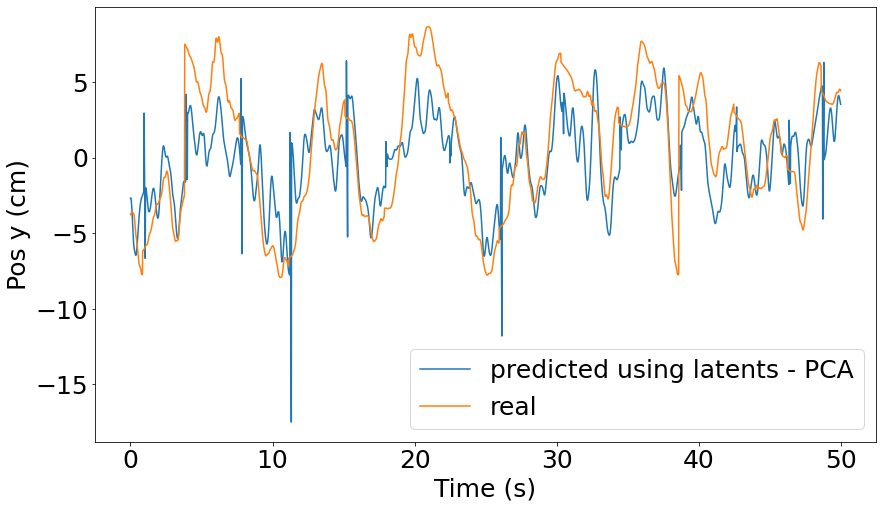

In [216]:
# real vs predicted hand trajectory in x - predicted by linear regression based on the latents found by PCA

time=0.02*np.arange(len(y_test_lr[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
# plt.plot(y_predict_rates_lr[0:2500, 0]) 
plt.plot(time, y_predict_pcs_lr[0:2500, 1]) 
plt.plot(time, y_test_lr[0:2500, 1])
plt.legend(['predicted using latents - PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in y for 25% of testing data: \n linear regression based on latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_y_PCA.jpeg')

Text(0.5, 1.0, 'Hand position in y for 25-30% testing data')

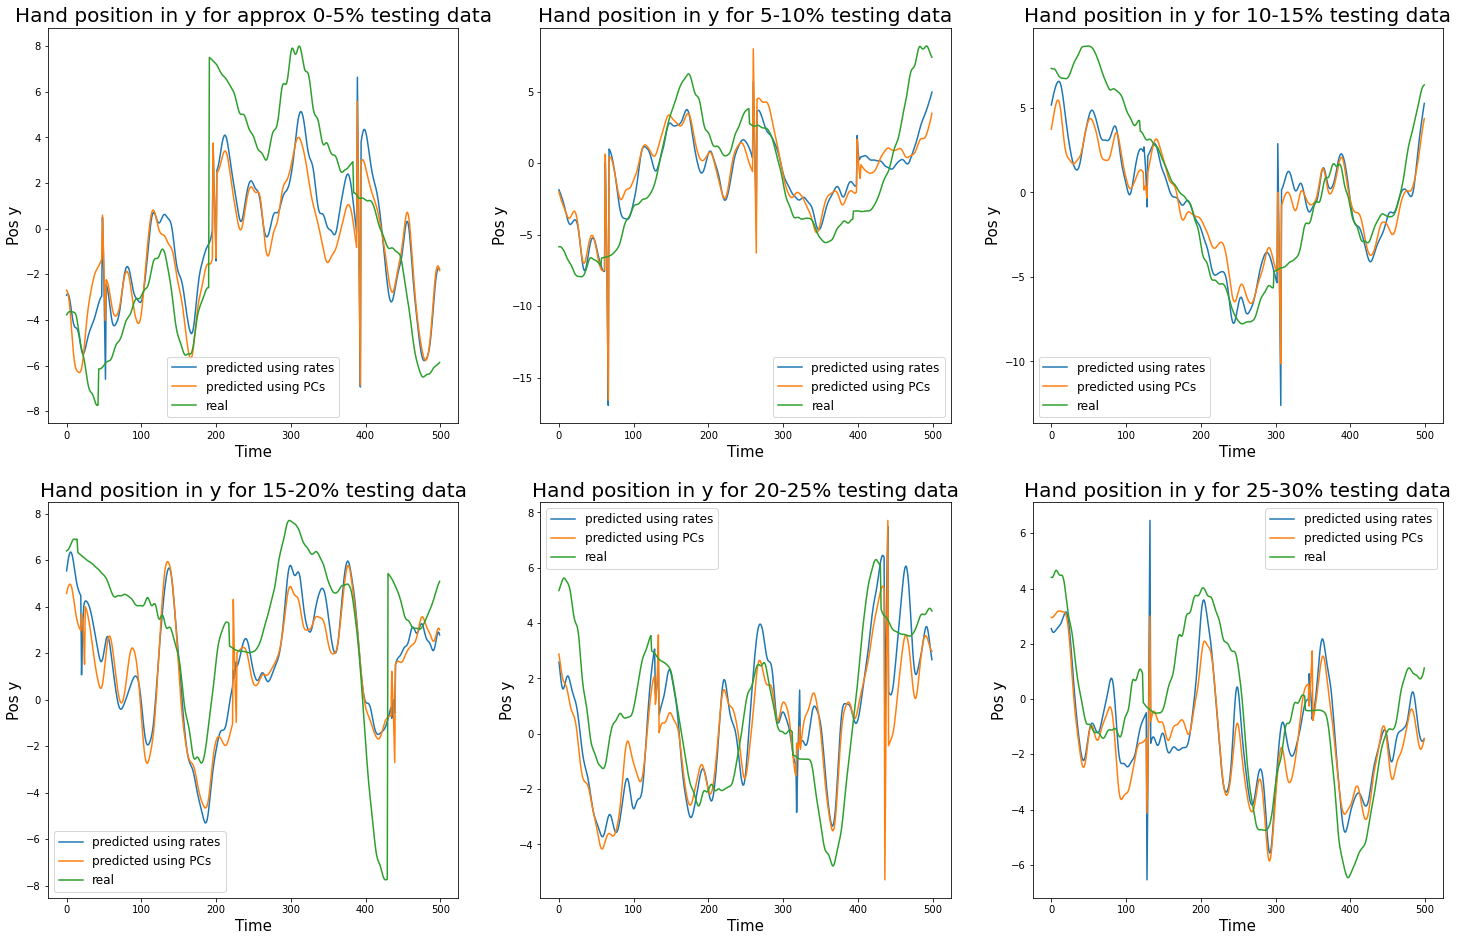

In [81]:
fig, ax = plt.subplots(figsize = (25, 16), nrows=2, ncols=3)
ax[0][0].plot(y_predict_rates_lr[0:500, 1]) 
ax[0][0].plot(y_predict_pcs_lr[0:500, 1]) 
ax[0][0].plot(y_test_lr[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_predict_rates_lr[500:1000, 1]) 
ax[0][1].plot(y_predict_pcs_lr[500:1000, 1]) 
ax[0][1].plot(y_test_lr[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_predict_rates_lr[1000:1500, 1]) 
ax[0][2].plot(y_predict_pcs_lr[1000:1500, 1]) 
ax[0][2].plot(y_test_lr[1000:1500, 1])
ax[0][2].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos y', fontsize=15)
ax[0][2].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_predict_rates_lr[1500:2000, 1]) 
ax[1][0].plot(y_predict_pcs_lr[1500:2000, 1])
ax[1][0].plot(y_test_lr[1500:2000, 1])
ax[1][0].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_predict_rates_lr[2000:2500, 1]) 
ax[1][1].plot(y_predict_pcs_lr[2000:2500, 1]) 
ax[1][1].plot(y_test_lr[2000:2500, 1])
ax[1][1].legend(['predicted using rates','predicted using PCs', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_predict_rates_lr[2500:3000, 1]) 
ax[1][2].plot(y_predict_pcs_lr[2500:3000, 1])
ax[1][2].plot(y_test_lr[2500:3000, 1])
ax[1][2].legend(['predicted using rates','predicted using PCs','real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos y', fontsize=15)
ax[1][2].set_title('Hand position in y for 25-30% testing data', fontsize=20)


# DECODING WITH LSTMs CONCATENATING ALL TRIALS 

In [75]:
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import keras
keras_v1=int(keras.__version__[0])<=1
keras_v1

False

In [76]:
from Neural_Decoding_folder import *
from Neural_Decoding_folder.Neural_Decoding.preprocessing_funcs import get_spikes_with_history
#Import metrics
from Neural_Decoding_folder.Neural_Decoding.metrics import get_R2
from Neural_Decoding_folder.Neural_Decoding.metrics import get_rho
#Import decoder functions
from Neural_Decoding_folder.Neural_Decoding.decoders import LSTMDecoder

In [77]:
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import keras
keras_v1=int(keras.__version__[0])<=1
keras_v1
import tensorflow as tf
from tensorflow.keras.models import Model

In [78]:
"""For use in decoding (see "Examples_all_decoders" and "Examples_kf_decoder"), 
we need the following format of inputs:

1. Neural data should be a matrix of size "number of time bins" x "number of neurons", 
where each entry is the firing rate of a given neuron in a given time bin

2. The output you are decoding should be a matrix of size "number of time bins" x "number
of features you are decoding" 

For all the decoders other than the Kalman filter, you can set "bins_before" 
(the number of bins of spikes preceding the output), "bins_current" (whether to use the bin of spikes 
concurrent with the output), and "bins_after" (the number of bins of spikes after the output). 
Let "surrounding_bins" = bins_before+bins_current+bins_after. 

This allows us to get a 3d covariate matrix "X" that has size 
"total number of time bins" x "surrounding_bins" x "number of neurons." 
We use this input format for the recurrent neural networks (SimpleRNN, GRU, LSTM). """

'For use in decoding (see "Examples_all_decoders" and "Examples_kf_decoder"), \nwe need the following format of inputs:\n\n1. Neural data should be a matrix of size "number of time bins" x "number of neurons", \nwhere each entry is the firing rate of a given neuron in a given time bin\n\n2. The output you are decoding should be a matrix of size "number of time bins" x "number\nof features you are decoding" \n\nFor all the decoders other than the Kalman filter, you can set "bins_before" \n(the number of bins of spikes preceding the output), "bins_current" (whether to use the bin of spikes \nconcurrent with the output), and "bins_after" (the number of bins of spikes after the output). \nLet "surrounding_bins" = bins_before+bins_current+bins_after. \n\nThis allows us to get a 3d covariate matrix "X" that has size \n"total number of time bins" x "surrounding_bins" x "number of neurons." \nWe use this input format for the recurrent neural networks (SimpleRNN, GRU, LSTM). '

USING FIRING RATES 

In [79]:
"""To do K-fold cross validation splitting dataset by trials need to use the extended matrix:
trials x time x neurons*6 --- but then when concatenating trials for training & testing, it becomes: 
all time x neurons*6 ---> reshape to be all time x neurons x 6 (where 6 is time bins before, current and after)

only this format can be processed by LSTMRegression - as defined by Glaser et al. """


bins_before=5

all_rates_hist_matrix=[[]]
for t in range (bins_before+1, len(all_rates)): 
    rates_hist=[]
    rates_hist.append(all_rates[t, :])
    rates_hist.append(all_rates[t-1, :])
    rates_hist.append(all_rates[t-2, :])
    rates_hist.append(all_rates[t-3, :])
    rates_hist.append(all_rates[t-4, :])
    rates_hist.append(all_rates[t-5, :])
    rates_hist=np.reshape(rates_hist, (1,(bins_before+1)*77))
    all_rates_hist_matrix.append(rates_hist)
all_rates_hist_matrix.pop(0)
len(all_rates_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
all_rates_hist_matrix=np.squeeze(all_rates_hist_matrix)
all_rates_hist_matrix=np.array(all_rates_hist_matrix)
all_rates_hist_matrix.shape #(99994, 180)

(99994, 462)

In [80]:
all_rates_hist_matrix.shape
type(all_rates_hist_matrix)
all_rates_hist=np.reshape(all_rates_hist_matrix,( len(all_rates_hist_matrix), 77, 6))
# all_rates_hist.shape # (99994, 77, 6)

In [81]:
pos_for_history=[[]]
pos_row=locs[6:,:]
pos_for_history.append(pos_row)
pos_for_history.pop(0)
len(pos_for_history) #1
#len(np.transpose(pos_for_history)) #2
locs_hist=pos_for_history[0][:, :]
locs_hist.shape #(99990, 2)

type(locs_hist)
locs_hist.shape

vel_for_history=[[]]
vel_row=vel[6:,:]
vel_for_history.append(vel_row)
vel_for_history.pop(0)
len(vel_for_history) #1
#len(np.transpose(pos_for_history)) #2
vel_hist=vel_for_history[0][:, :]
vel_hist.shape #(99990, 2)

type(vel_hist)
vel_hist.shape

(99994, 2)

In [82]:
model_lstm=LSTMDecoder(units=400, dropout=0, num_epochs=5)

In [91]:
""" import torch
import mgplvm as mgp # to clone 

torch.cuda.is_available()

np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU

device='cpu' """

" import torch\nimport mgplvm as mgp # to clone \n\ntorch.cuda.is_available()\n\nnp.random.seed(0)\ntorch.manual_seed(0)\ndevice = mgp.utils.get_device() # use GPU if available, otherwise CPU\n\ndevice='cpu' "

In [92]:
# CV scores for LSTM based on rates - change between locs_hist/vel_hist to predict position or velocity

scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist[0:90000, :, :]): 
    X_train = all_rates_hist[training, :, :]
    X_test = all_rates_hist[testing, :, :] 
    Y_train = locs_hist[training, :]
    Y_test = locs_hist[testing, :]
    #testing_vector.append(testing)
    #model = LSTMDecoder(units=400,dropout=0,num_epochs=5)   #no need to redefine at iteration 
    model_lstm.fit(X_train, Y_train)
    y_test_predicted_lstm=model_lstm.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
    
# calculated in the case without neural delay adjustment     
#          scores FOR VELOCITY 
"""[array([0.95597108, 0.95097876]),
 array([0.95001408, 0.94883948]),
 array([0.95340578, 0.95012732]),
 array([0.94936236, 0.94690591]),
 array([0.95595663, 0.95220971]),
 array([0.95581072, 0.94763706]),
 array([0.95881756, 0.95055216]),
 array([0.95120518, 0.94630818]),
 array([0.95268704, 0.95205219]),
 array([0.95114964, 0.94769666])]"""

#          scores FOR POSITION
"""[array([0.97745602, 0.97748025]),
 array([0.97567137, 0.97849039]),
 array([0.97580711, 0.97772142]),
 array([0.97434582, 0.9791986 ]),
 array([0.9749096 , 0.97875781]),
 array([0.97575527, 0.97805503]),
 array([0.97359311, 0.97772923]),
 array([0.97334644, 0.97805531]),
 array([0.97756795, 0.97994865]),
 array([0.97686266, 0.9813002 ])]"""

# calculated in the case with neural delay adjustment     
#          scores FOR POSITION
"""[array([0.97861357, 0.97951551]),
 array([0.97827874, 0.98139043]),
 array([0.97688782, 0.97815819]),
 array([0.97703992, 0.97898335]),
 array([0.9727939 , 0.97901638]),
 array([0.97892395, 0.98148823]),
 array([0.97971564, 0.98151762]),
 array([0.97642098, 0.97997387]),
 array([0.9801565 , 0.97727625]),
 array([0.97787114, 0.97920781])]"""
# ultimately the same, not big variations, consider without neural delay adjustment and use those 

2022-06-13 00:08:00.762453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:08:00.767787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:08:00.768088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 00:08:00.768328: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1953] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.6. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2022-06-13 00:08:00.768673: I tensorflow/core/platform/cpu_feature_guard.cc:151] 

'[array([0.97745602, 0.97748025]),\n array([0.97567137, 0.97849039]),\n array([0.97580711, 0.97772142]),\n array([0.97434582, 0.9791986 ]),\n array([0.9749096 , 0.97875781]),\n array([0.97575527, 0.97805503]),\n array([0.97359311, 0.97772923]),\n array([0.97334644, 0.97805531]),\n array([0.97756795, 0.97994865]),\n array([0.97686266, 0.9813002 ])]'

USING LATENTS 

In [83]:
bins_before=5

all_pcs_hist_matrix=[[]]
for t in range (bins_before+1, len(all_rates)): 
    pcs_hist=[]
    pcs_hist.append(all_pcs[t, :])
    pcs_hist.append(all_pcs[t-1, :])
    pcs_hist.append(all_pcs[t-2, :])
    pcs_hist.append(all_pcs[t-3, :])
    pcs_hist.append(all_pcs[t-4, :])
    pcs_hist.append(all_pcs[t-5, :])
    pcs_hist=np.reshape(pcs_hist, (1,(bins_before+1)*30))
    all_pcs_hist_matrix.append(pcs_hist)
all_pcs_hist_matrix.pop(0)
len(all_pcs_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
all_pcs_hist_matrix=np.squeeze(all_pcs_hist_matrix)
all_pcs_hist_matrix=np.array(all_pcs_hist_matrix)
all_pcs_hist_matrix.shape #(99994, 180)

all_pcs_hist_matrix.shape
type(all_pcs_hist_matrix)
all_pcs_hist=np.reshape(all_pcs_hist_matrix,( len(all_pcs_hist_matrix), 30, 6))
# all_pcs_hist.shape # (99994, 30, 6)

In [ ]:
# CV scores for LSTM based on latents found by PCA - change between locs_hist/vel_hist to predict position or velocity

scores=[]
train=[]
test=[]
model_lstm=LSTMDecoder(units=400, dropout=0, num_epochs=5)
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_pcs_hist): 
    X_train = all_pcs_hist[training, :, :]
    X_test = all_pcs_hist[testing, :, :] 
    Y_train = vel_hist[training, :]
    Y_test = vel_hist[testing, :]
    #testing_vector.append(testing)
    #model = LSTMDecoder(units=400,dropout=0,num_epochs=5)   #no need to redefine at iteration 
    model_lstm.fit(X_train, Y_train)
    y_test_predicted_lstm=model_lstm.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
    
#          scores FOR VELOCITY 
"""
[array([0.96255548, 0.95776219]),
 array([0.95973464, 0.95696231]),
 array([0.9598874 , 0.95811964]),
 array([0.96243119, 0.95990905]),
 array([0.96090319, 0.9609399 ]),
 array([0.96223392, 0.95951015]),
 array([0.96197628, 0.95792669]),
 array([0.96100978, 0.95902386]),
 array([0.96276608, 0.96056491]),
 array([0.96212506, 0.9569561 ])]
"""

#          scores FOR POSITION
"""
[array([0.97974532, 0.9807244 ]),
 array([0.97808459, 0.98005306]),
 array([0.97886193, 0.98177455]),
 array([0.97954095, 0.98014698]),
 array([0.97861696, 0.98126859]),
 array([0.97881041, 0.98143323]),
 array([0.97956185, 0.98209167]),
 array([0.98063652, 0.9821061 ]),
 array([0.97905856, 0.9820066 ]),
 array([0.97960072, 0.98064705])]
"""

In [84]:
# STORING THE CV SCORES FOR LSTM 

avg_cv_vel_x_rates=np.mean([0.95597108,0.95001408,0.95340578,0.94936236,0.95595663,0.95581072,0.95881756,
                  0.95120518,0.95268704,0.95114964])
avg_cv_vel_y_rates=np.mean([0.95097876, 0.94883948, 0.95012732, 0.94690591, 0.95220971, 0.94763706, 0.95055216, 
                  0.94630818, 0.95205219, 0.94769666])
avg_cv_pos_x_rates=np.mean([0.97745602, 0.97567137, 0.97580711, 0.97434582, 0.9749096 , 0.97575527, 0.97359311, 
                   0.97334644, 0.97756795, 0.97686266])
avg_cv_pos_y_rates=np.mean([0.97748025, 0.97849039, 0.97772142, 0.9791986, 0.97875781, 0.97805503, 0.97772923,
                   0.97805531, 0.97994865, 0.9813002])
avg_cv_vel_x_pcs=np.mean([0.96255548, 0.95973464, 0.9598874 , 0.96243119, 0.96090319, 0.96223392, 0.96197628, 
                          0.96100978, 0.96276608, 0.96212506])
avg_cv_vel_y_pcs=np.mean([0.95776219, 0.95696231, 0.95811964, 0.95990905, 0.9609399 , 0.95951015, 
                          0.95792669, 0.95902386, 0.96056491, 0.9569561])
avg_cv_pos_x_pcs=np.mean([0.97974532, 0.97808459, 0.97886193, 0.97954095, 0.97861696, 0.97881041, 
                          0.97956185, 0.98063652, 0.97905856, 0.97960072])
avg_cv_pos_y_pcs=np.mean([0.9807244 , 0.98005306, 0.98177455, 0.98014698, 0.98126859, 0.98143323, 
                          0.98209167, 0.9821061 , 0.9820066 , 0.98064705])

# Dataframe with cv scores for velocity & position predicted by LSTM using smoothed rated or latents by PCA
# OVERALL SHOWING THAT RIDGE DOES NOT ENHANCE PERFORMANCE 
cv_lstm_rates = {'CV':['AVERAGE SCORE' ], 
     'Vel_x Rates': avg_cv_vel_x_rates ,
     'Vel_y Rates': avg_cv_vel_y_rates ,
     'Pos_x Rates': avg_cv_pos_x_rates ,
     'Pos_y Rates': avg_cv_pos_y_rates , 
     'Vel_x Latents': avg_cv_vel_x_pcs ,
     'Vel_y Latents': avg_cv_vel_y_pcs ,
     'Pos_x Latents': avg_cv_pos_x_pcs ,
     'Pos_y Latents': avg_cv_pos_y_pcs  
    }
pd.set_option('display.max_columns', None)
cv_lstm_rates_mean = pd.DataFrame(data=cv_lstm_rates)
cv_lstm_rates_mean

CV  Vel_x Rates  Vel_y Rates  Pos_x Rates  Pos_y Rates  \
0  AVERAGE SCORE     0.953438     0.949331     0.975532     0.978674   

   Vel_x Latents  Vel_y Latents  Pos_x Latents  Pos_y Latents  
0       0.961562       0.958767       0.979252       0.981225

In [85]:
# Dataframe with cv scores for velocity & position predicted by LSTM using smoothed rated 

cv_vel_x_rates=[0.95597108,0.95001408,0.95340578,0.94936236,0.95595663,0.95581072,0.95881756,
                  0.95120518,0.95268704,0.95114964]
cv_vel_y_rates=[0.95097876, 0.94883948, 0.95012732, 0.94690591, 0.95220971, 0.94763706, 0.95055216, 
                  0.94630818, 0.95205219, 0.94769666]
cv_pos_x_rates=[0.97745602, 0.97567137, 0.97580711, 0.97434582, 0.9749096 , 0.97575527, 0.97359311, 
                   0.97334644, 0.97756795, 0.97686266]
cv_pos_y_rates=[0.97748025, 0.97849039, 0.97772142, 0.9791986, 0.97875781, 0.97805503, 0.97772923,
                   0.97805531, 0.97994865, 0.9813002]

rates_LSTM = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_vel_x_rates,
     'Vel_y': cv_vel_y_rates,
     'Pos_x': cv_pos_x_rates ,
     'Pos_y': cv_pos_y_rates ,
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_rates = pd.DataFrame(data=rates_LSTM)
cv_scores_LSTM_rates

""" fig, ax = plt.subplots(figsize = (7, 4))
boxplot_LSTM_rates = cv_scores_LSTM_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_LSTM_rates.set_title('10-fold CV, scores - LSTM, using Firing Rates as an Input', fontsize=13)
boxplot_LSTM_rates.set_ylim([0.945, 0.984])
boxplot_LSTM_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('LSTM_scores_rates.jpeg') """


" fig, ax = plt.subplots(figsize = (7, 4))\nboxplot_LSTM_rates = cv_scores_LSTM_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_LSTM_rates.set_title('10-fold CV, scores - LSTM, using Firing Rates as an Input', fontsize=13)\nboxplot_LSTM_rates.set_ylim([0.945, 0.984])\nboxplot_LSTM_rates.set_xlabel('Output Field', fontsize=13)\nplt.savefig('LSTM_scores_rates.jpeg') "

In [86]:
# Dataframe with cv scores for velocity & position predicted by LSTM using latents by PCA

cv_vel_x_pcs=[0.96255548, 0.95973464, 0.9598874 , 0.96243119, 0.96090319, 0.96223392, 0.96197628, 
                          0.96100978, 0.96276608, 0.96212506]
cv_vel_y_pcs=[0.95776219, 0.95696231, 0.95811964, 0.95990905, 0.9609399 , 0.95951015, 
                          0.95792669, 0.95902386, 0.96056491, 0.9569561]
cv_pos_x_pcs=[0.97974532, 0.97808459, 0.97886193, 0.97954095, 0.97861696, 0.97881041, 
                          0.97956185, 0.98063652, 0.97905856, 0.97960072]
cv_pos_y_pcs=[0.9807244 , 0.98005306, 0.98177455, 0.98014698, 0.98126859, 0.98143323, 
                          0.98209167, 0.9821061 , 0.9820066 , 0.98064705]

pcs_LSTM = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_vel_x_pcs,
     'Vel_y': cv_vel_y_pcs,
     'Pos_x': cv_pos_x_pcs ,
     'Pos_y': cv_pos_y_pcs ,
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_pcs = pd.DataFrame(data=pcs_LSTM)
cv_scores_LSTM_pcs

""" fig, ax = plt.subplots(figsize = (7, 4))
boxplot_LSTM_pcs = cv_scores_LSTM_pcs.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_LSTM_pcs.set_title('10-fold CV, scores - LSTM, using the Latents as an Input', fontsize=13)
boxplot_LSTM_pcs.set_ylim([0.945, 0.984])
boxplot_LSTM_pcs.set_xlabel('Output Field', fontsize=13)
plt.savefig('LSTM_scores_pcs.jpeg') """


" fig, ax = plt.subplots(figsize = (7, 4))\nboxplot_LSTM_pcs = cv_scores_LSTM_pcs.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_LSTM_pcs.set_title('10-fold CV, scores - LSTM, using the Latents as an Input', fontsize=13)\nboxplot_LSTM_pcs.set_ylim([0.945, 0.984])\nboxplot_LSTM_pcs.set_xlabel('Output Field', fontsize=13)\nplt.savefig('LSTM_scores_pcs.jpeg') "

In [87]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

cv_rates_LSTM = [cv_pos_x_rates,cv_pos_y_rates, cv_vel_x_rates, cv_vel_y_rates ]
cv_pcs_LSTM = [cv_pos_x_pcs,cv_pos_y_pcs, cv_vel_x_pcs,cv_vel_y_pcs ]

""" fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_pcs_LSTM, 'red', 'tan')
bp2 = box_plot(cv_rates_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PCA', 'Firing Rates'], fontsize=13)
ax.set_ylim(0.92, 1)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: LSTM based on the rates \n and the latents found by PCA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LSTM_scores_PCAvsRates.jpeg') """

' fig, ax = plt.subplots(figsize = (7, 5))\nbp1 = box_plot(cv_pcs_LSTM, \'red\', \'tan\')\nbp2 = box_plot(cv_rates_LSTM, \'blue\', \'cyan\')\nax.legend([bp1["boxes"][0], bp2["boxes"][0]], [\'PCA\', \'Firing Rates\'], fontsize=13)\nax.set_ylim(0.92, 1)\nax.set_ylabel(\'R$^2$\', fontsize=15)\nax.set_xlabel(\'Output Field\', fontsize=15)\nax.set_title(\'CV scores: LSTM based on the rates \n and the latents found by PCA\', fontsize=15)\n# plt.set_xticks([\'posx\', \'posy\', \'velx\', \'vely\'])\nplt.xticks([1, 2, 3, 4], [\'Pos x\', \'Pos y\', \'Vel x\', \'Vel y\'], fontsize=13)\nplt.savefig(\'LSTM_scores_PCAvsRates.jpeg\') '

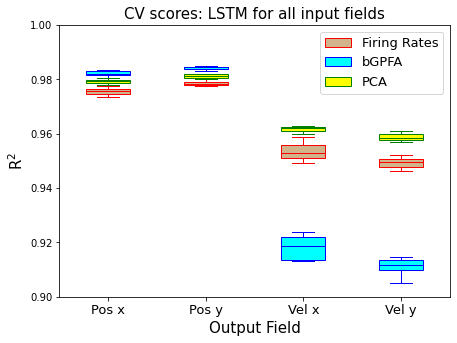

In [120]:
# Storing CV scores for LSTM based on bGPFA-inferred latents found by PCA 

cv_vel_x_bGPFA_LSTM=[0.92140937, 0.92368591, 0.91340234, 0.91316433, 0.91654864, 
                         0.91306687, 0.92118182, 0.92222493, 0.92290897, 0.9133583]
cv_vel_y_bGPFA_LSTM=[0.91351966, 0.91452149, 0.90511381, 0.90971211, 0.91054961, 
                         0.90250338, 0.91143649, 0.91987674, 0.91372856, 0.9117656]
cv_pos_x_bGPFA_LSTM=[0.98197556, 0.98131631, 0.98224821, 0.98336054, 0.98361033, 
                         0.98121074, 0.9824812 , 0.98194076, 0.98345611, 0.98049719]
cv_pos_y_bGPFA_LSTM=[0.98451036, 0.98473229, 0.98313725, 0.98607687, 0.98458969, 
                         0.984394  , 0.98445498, 0.98483623, 0.98325001, 0.98377365]


# COMPARATIVE BOXPLOT of CV SCORES for LINEAR REGRESSION 
# CROSS-COMPARISON AMONST 3 INPUT FIELDS FOR LSTM

cv_rates_LSTM = [cv_pos_x_rates,cv_pos_y_rates, cv_vel_x_rates, cv_vel_y_rates ]
cv_pcs_LSTM = [cv_pos_x_pcs,cv_pos_y_pcs, cv_vel_x_pcs,cv_vel_y_pcs ]
cv_bGPFA_LSTM = [cv_pos_x_bGPFA_LSTM, cv_pos_y_bGPFA_LSTM, cv_vel_x_bGPFA_LSTM, cv_vel_y_bGPFA_LSTM]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_LSTM, 'red', 'tan')
bp2 = box_plot(cv_bGPFA_LSTM, 'blue', 'cyan')
bp3 = box_plot(cv_pcs_LSTM, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Firing Rates', 'bGPFA', 'PCA'], fontsize=13)
ax.set_ylim(0.9, 1)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: LSTM for all input fields', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LSTM_COMPARISON_FIELDS.jpeg')

COMPUTING PREDICTIONS 

In [218]:
# USING RATES 

neural_data = all_rates # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

X_train=Y[10:90000, :, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y[90000:99999, :, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_lstm.fit(X_train, y_train)

#Test model 
y_test_predicted_lstm_rates=model_lstm.predict(X_test)
R2s_lstm_test_rates=get_R2(y_test, y_test_predicted_lstm_rates)
print('R2s:', R2s_lstm_test_rates) 

2022-06-13 22:46:58.213655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 22:46:58.221402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 22:46:58.221730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 22:46:58.221997: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1953] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.6. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2022-06-13 22:46:58.222592: I tensorflow/core/platform/cpu_feature_guard.cc:151] 

R2s: [0.67319766 0.7300868 ]


In [219]:
# USING PCs

neural_data = all_pcs # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

X_train=Y[10:90000, :, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y[90000:99999, :, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_lstm.fit(X_train, y_train)

#Test model 
y_test_predicted_lstm_pcs=model_lstm.predict(X_test)
R2s_lstm_test_pcs=get_R2(y_test, y_test_predicted_lstm_pcs)
print('R2s:', R2s_lstm_test_pcs) 

R2s: [0.60258638 0.69557534]


Text(0.5, 1.0, 'Hand position in x for 25-30% testing data')

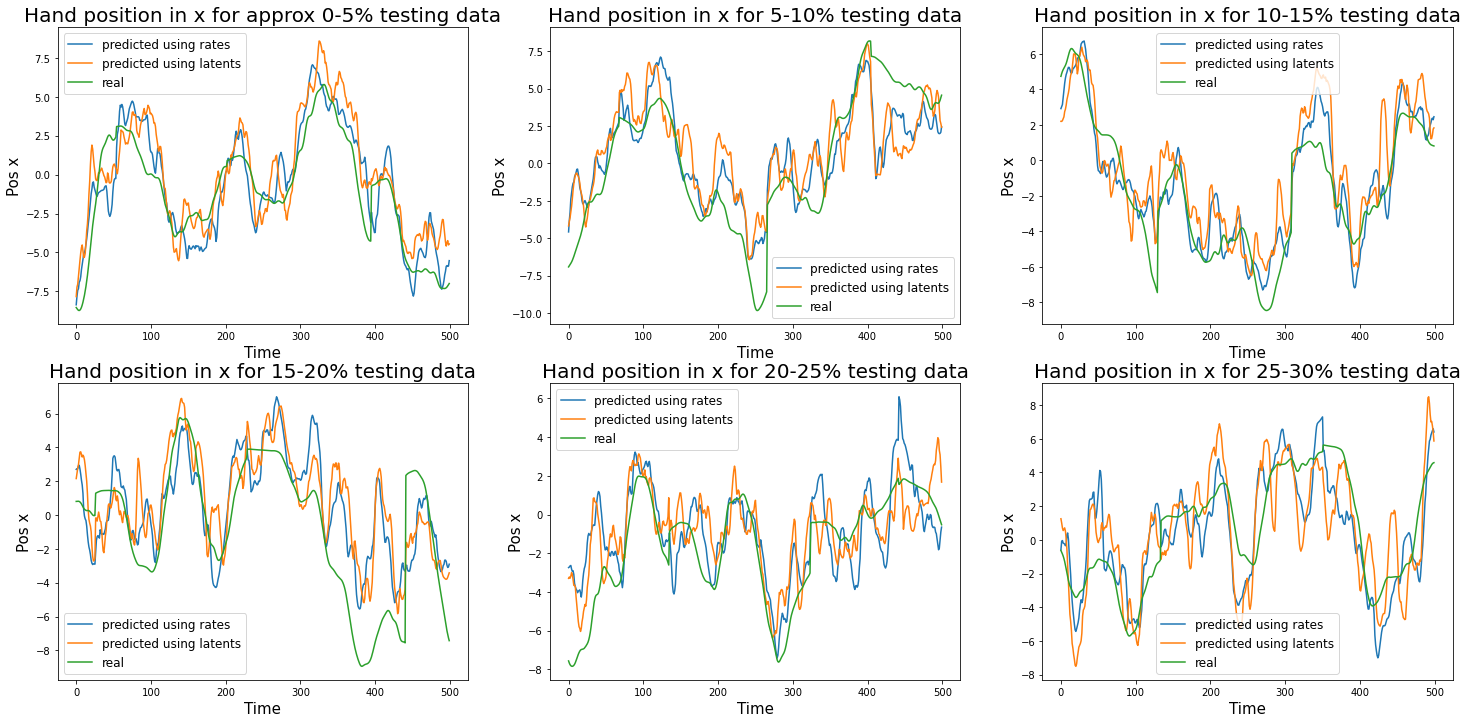

In [131]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_lstm_rates[0:500, 0]) 
ax[0][0].plot(y_test_predicted_lstm_pcs[0:500, 0]) 
ax[0][0].plot(y_test[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_lstm_rates[500:1000, 0]) 
ax[0][1].plot(y_test_predicted_lstm_pcs[500:1000, 0]) 
ax[0][1].plot(y_test[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_lstm_rates[1000:1500, 0]) 
ax[0][2].plot(y_test_predicted_lstm_pcs[1000:1500, 0]) 
ax[0][2].plot(y_test[1000:1500, 0])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos x', fontsize=15)
ax[0][2].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_lstm_rates[1500:2000, 0]) 
ax[1][0].plot(y_test_predicted_lstm_pcs[1500:2000, 0]) 
ax[1][0].plot(y_test[1500:2000, 0])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_lstm_rates[2000:2500, 0]) 
ax[1][1].plot(y_test_predicted_lstm_pcs[2000:2500, 0]) 
ax[1][1].plot(y_test[2000:2500, 0])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_lstm_rates[2500:3000, 0]) 
ax[1][2].plot(y_test_predicted_lstm_pcs[2500:3000, 0]) 
ax[1][2].plot(y_test[2500:3000, 0])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos x', fontsize=15)
ax[1][2].set_title('Hand position in x for 25-30% testing data', fontsize=20)

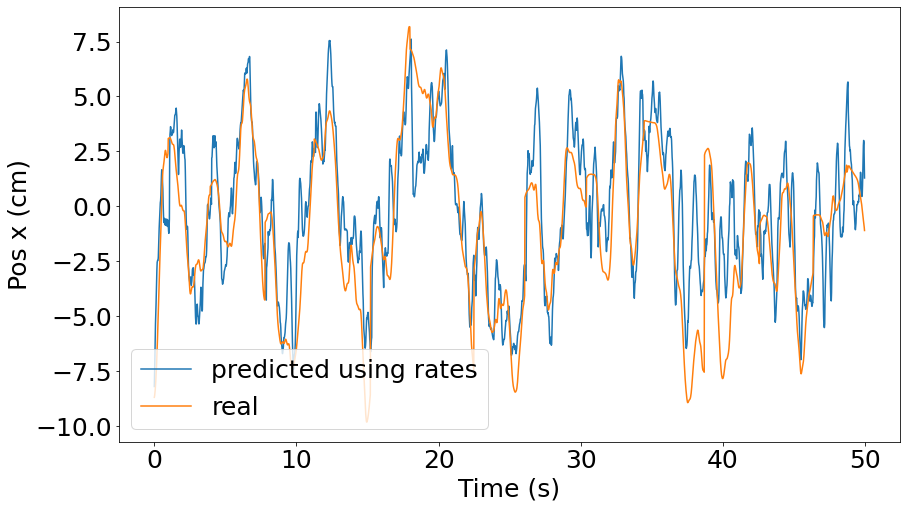

In [221]:
# real vs predicted hand trajectory in x - predicted by LSTM based on the smoothed rates

time=0.02*np.arange(len(y_test[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_rates[0:2500, 0]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n LSTM based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_x_Rates.jpeg')

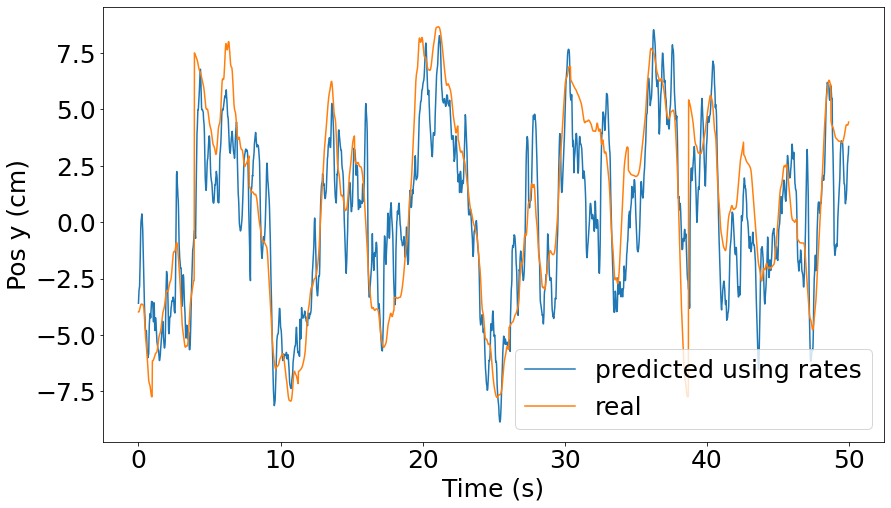

In [222]:
# real vs predicted hand trajectory in y - predicted by LSTM based on the smoothed rates

time=0.02*np.arange(len(y_test[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_rates[0:2500, 1]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in y for 25% of testing data: \n LSTM based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_y_Rates.jpeg')

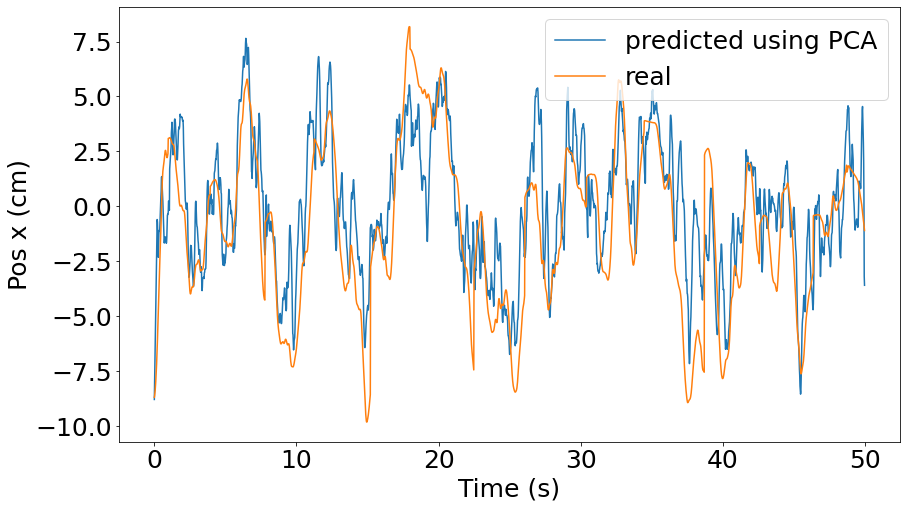

In [223]:
# real vs predicted hand trajectory in x - predicted by LSTM based on the latents found by PCA

time=0.02*np.arange(len(y_test[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_pcs[0:2500, 0]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n LSTM based on the latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_x_PCA.jpeg')

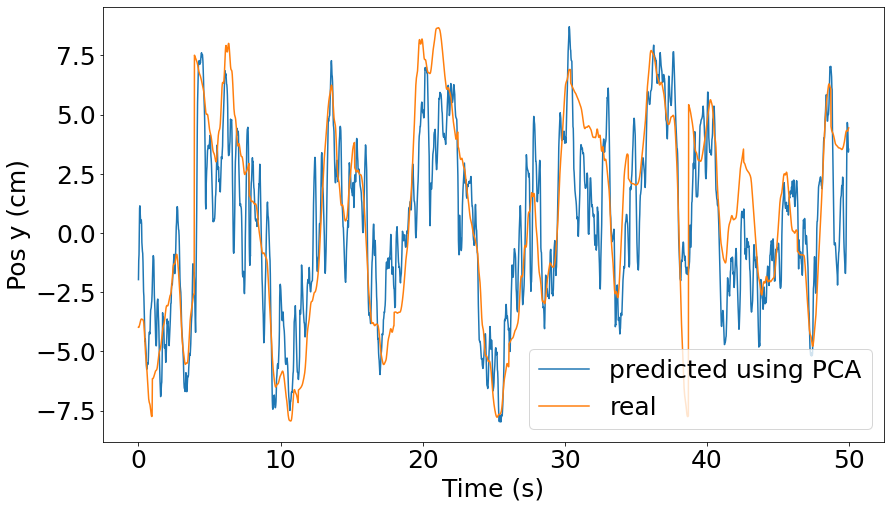

In [224]:
# real vs predicted hand trajectory in y - predicted by LSTM based on the latents found by PCA

time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_pcs[0:2500, 1]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
#plt.title('Real & predicted hand position in y for 25% of testing data: \n LSTM based on the latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_y_PCA.jpeg')

Text(0.5, 1.0, 'Hand position in y for 25-30% testing data')

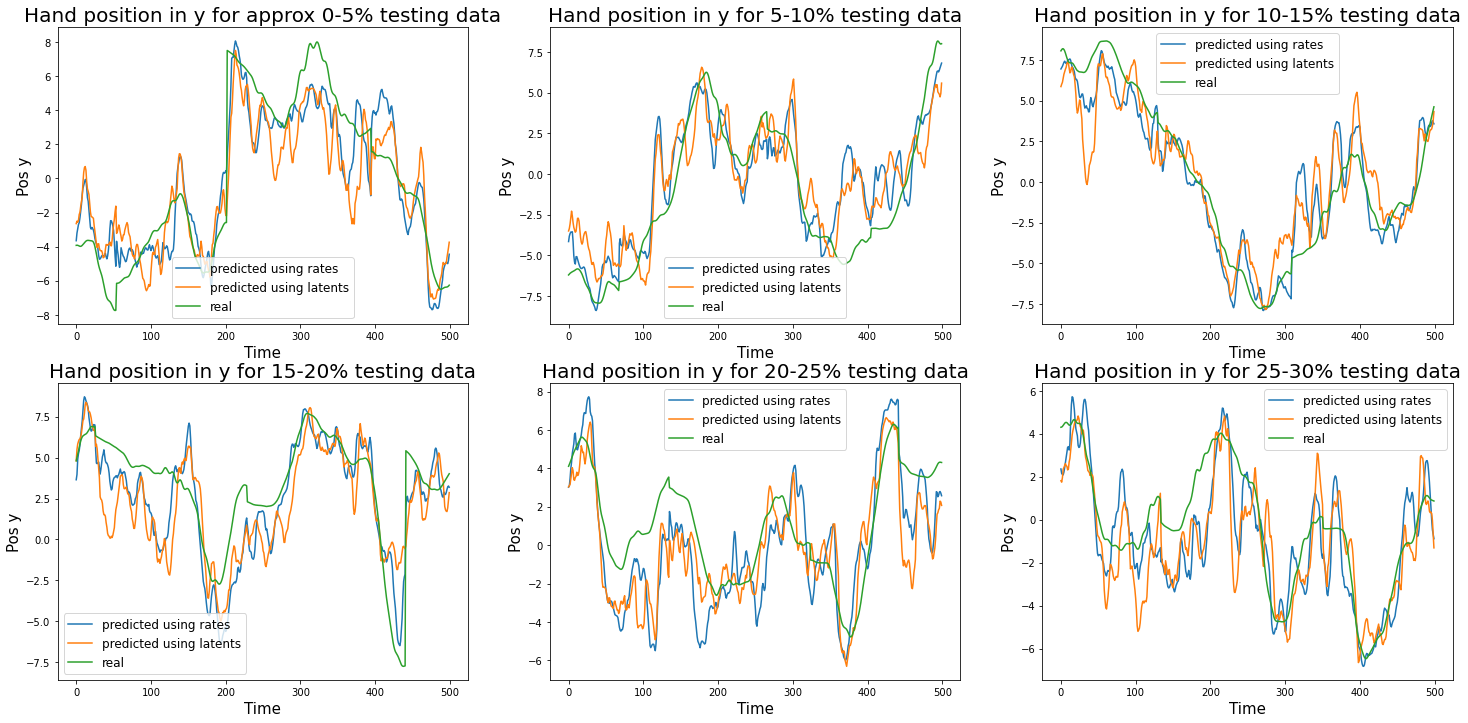

In [100]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_lstm_rates[0:500, 1]) 
ax[0][0].plot(y_test_predicted_lstm_pcs[0:500, 1]) 
ax[0][0].plot(y_test[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_lstm_rates[500:1000, 1]) 
ax[0][1].plot(y_test_predicted_lstm_pcs[500:1000, 1]) 
ax[0][1].plot(y_test[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_lstm_rates[1000:1500, 1]) 
ax[0][2].plot(y_test_predicted_lstm_pcs[1000:1500, 1]) 
ax[0][2].plot(y_test[1000:1500, 1])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos y', fontsize=15)
ax[0][2].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_lstm_rates[1500:2000, 1]) 
ax[1][0].plot(y_test_predicted_lstm_pcs[1500:2000, 1]) 
ax[1][0].plot(y_test[1500:2000, 1])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_lstm_rates[2000:2500, 1]) 
ax[1][1].plot(y_test_predicted_lstm_pcs[2000:2500, 1]) 
ax[1][1].plot(y_test[2000:2500, 1])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_lstm_rates[2500:3000, 1]) 
ax[1][2].plot(y_test_predicted_lstm_pcs[2500:3000, 1]) 
ax[1][2].plot(y_test[2500:3000, 1])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos y', fontsize=15)
ax[1][2].set_title('Hand position in y for 25-30% testing data', fontsize=20)

# DECODING WITH DENSE NN REGRESSION CONCATENATING ALL TRIALS

In [225]:
from Neural_Decoding_folder.Neural_Decoding.decoders_copy import DenseNNRegression

In [226]:
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import keras
keras_v1=int(keras.__version__[0])<=1
keras_v1

from Neural_Decoding_folder import *
from Neural_Decoding_folder.Neural_Decoding.preprocessing_funcs import get_spikes_with_history
#Import metrics
from Neural_Decoding_folder.Neural_Decoding.metrics import get_R2
from Neural_Decoding_folder.Neural_Decoding.metrics import get_rho
#Import decoder functions
from Neural_Decoding_folder.Neural_Decoding.decoders import LSTMDecoder

from keras.layers import Dense, LSTM
from keras.utils import np_utils
import keras
keras_v1=int(keras.__version__[0])<=1
keras_v1
import tensorflow as tf
from tensorflow.keras.models import Model

In [227]:
model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)

In [105]:
# CV scores for multilayer perceptron based on the smoothed rates
# change between locs_hist/vel_hist to predict position or velocity

# for Cross Validation, use all_rates_hist_matrix which has shape [ Time x (Neurons * Bins History) ]
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist): 
    X_train = all_rates_hist_matrix[training,  :]
    X_test = all_rates_hist_matrix[testing, :] 
    Y_train = locs_hist[training, :]
    Y_test = locs_hist[testing, :]
    #testing_vector.append(testing)
    model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)
    model_dense.fit(X_train, Y_train)
    y_test_predicted_lstm=model_dense.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)

# calculated in the case without neural delay adjustment 
""" for locations 
[array([0.8233847 , 0.84024272]),
 array([0.82906518, 0.83561525]),
 array([0.82345953, 0.83405889]),
 array([0.82028517, 0.84231822]),
 array([0.82678134, 0.84800925]),
 array([0.81013378, 0.84162517]),
 array([0.82723866, 0.84535497]),
 array([0.83613947, 0.84556877]),
 array([0.83983654, 0.84294712]),
 array([0.82735873, 0.84398514])] """

""" for velocity 
[array([0.80441954, 0.81500518]),
 array([0.79928293, 0.81888135]),
 array([0.80357315, 0.75859067]),
 array([0.81350946, 0.81360276]),
 array([0.80898845, 0.81469663]),
 array([0.78428285, 0.81696609]),
 array([0.82245284, 0.81211475]),
 array([0.82039151, 0.82218446]),
 array([0.7824337 , 0.80848091]),
 array([0.81587852, 0.80730602])]"""

# calculated in the case with neural delay adjustment
"""for position 
[array([0.82177472, 0.81404976]),
 array([0.82388752, 0.82607875]),
 array([0.8343866 , 0.85233465]),
 array([0.81355889, 0.82075054]),
 array([0.83952349, 0.83716234]),
 array([0.81479433, 0.83470978]),
 array([0.83119426, 0.82159119]),
 array([0.83614858, 0.86193825]),
 array([0.82210097, 0.81315837]),
 array([0.80698058, 0.8226083 ])] """

# ultimately the same so consider the case without neural delay adjustment as general 

' for velocity \n[array([0.80441954, 0.81500518]),\n array([0.79928293, 0.81888135]),\n array([0.80357315, 0.75859067]),\n array([0.81350946, 0.81360276]),\n array([0.80898845, 0.81469663]),\n array([0.78428285, 0.81696609]),\n array([0.82245284, 0.81211475]),\n array([0.82039151, 0.82218446]),\n array([0.7824337 , 0.80848091]),\n array([0.81587852, 0.80730602])]'

In [106]:
scores

[array([0.82177472, 0.81404976]),
 array([0.82388752, 0.82607875]),
 array([0.8343866 , 0.85233465]),
 array([0.81355889, 0.82075054]),
 array([0.83952349, 0.83716234]),
 array([0.81479433, 0.83470978]),
 array([0.83119426, 0.82159119]),
 array([0.83614858, 0.86193825]),
 array([0.82210097, 0.81315837]),
 array([0.80698058, 0.8226083 ])]

In [ ]:
# CV scores for multilayer perceptron based on the latents found by PCA
# change between locs_hist/vel_hist to predict position or velocity

# for Cross Validation, use all_pcs_hist_matrix which has shape [ Time x (Neurons * Bins History) ]
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist): 
    X_train = all_pcs_hist_matrix[training,  :]
    X_test = all_pcs_hist_matrix[testing, :] 
    Y_train = vel_hist[training, :]
    Y_test = vel_hist[testing, :]
    #testing_vector.append(testing)
    model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)
    model_dense.fit(X_train, Y_train)
    y_test_predicted_lstm=model_dense.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
""" for location 
[array([0.75607866, 0.77024936]),
 array([0.73734639, 0.7794667 ]),
 array([0.76155067, 0.78134116]),
 array([0.75910278, 0.79755761]),
 array([0.74834655, 0.77641576]),
 array([0.75275754, 0.78696633]),
 array([0.75673328, 0.78504122]),
 array([0.7659472, 0.7576299]),
 array([0.7507867 , 0.78901215]),
 array([0.75227577, 0.79893567])] """

""" for velocity
[array([0.80799383, 0.80455076]),
 array([0.80436695, 0.78880083]),
 array([0.81738748, 0.79638452]),
 array([0.79559023, 0.78943257]),
 array([0.80233594, 0.81037752]),
 array([0.78571621, 0.80227519]),
 array([0.79753201, 0.79149323]),
 array([0.80495206, 0.80432656]),
 array([0.80838966, 0.79291125]),
 array([0.80580045, 0.795676  ])]
"""

In [92]:
# storing cv scores for multilayer perceptron based on the smoothed rates and on the latents found by PCA 

cv_vel_x_rates_dense=[0.80441954, 0.79928293, 0.80357315, 0.81350946, 0.80898845, 0.78428285, 
                0.82245284, 0.82039151, 0.7824337 , 0.81587852]
cv_vel_y_rates_dense=[0.81500518, 0.81888135, 0.75859067, 0.81360276, 0.81469663, 0.81696609, 
                0.81211475, 0.82218446, 0.80848091, 0.80730602]
cv_pos_x_rates_dense=[0.8233847 , 0.82906518, 0.82345953, 0.82028517, 0.82678134, 0.81013378, 
                0.82723866, 0.83613947, 0.83983654, 0.82735873]
cv_pos_y_rates_dense=[0.84024272, 0.83561525, 0.83405889, 0.84231822, 0.84800925, 0.84162517, 
                0.84535497, 0.84556877, 0.84294712, 0.84398514]

cv_vel_x_pcs_dense=[0.80799383, 0.80436695, 0.81738748, 0.79559023, 0.80233594, 0.78571621, 
              0.79753201, 0.80495206, 0.80838966, 0.80580045]
cv_vel_y_pcs_dense=[0.80455076, 0.78880083, 0.79638452, 0.78943257, 0.81037752, 0.80227519, 
              0.79149323, 0.80432656, 0.79291125, 0.795676 ]
cv_pos_x_pcs_dense=[0.75607866, 0.73734639, 0.76155067, 0.75910278, 0.74834655, 0.75275754, 
              0.75673328, 0.7659472, 0.7507867 , 0.75227577]
cv_pos_y_pcs_dense=[0.77024936, 0.7794667 , 0.78134116, 0.79755761, 0.77641576, 0.78696633, 
              0.78504122, 0.7576299, 0.78901215, 0.79893567]

In [93]:
# OVERALL SHOWING THAT RIDGE DOES NOT ENHANCE PERFORMANCE 

# Dataframe storing cv scores for multilayer perceptron based on rates and latents by PCA
cv_dense_rates = {'CV':['AVERAGE SCORE' ], 
     'Rates Vel_x': np.mean(cv_vel_x_rates_dense) ,
     'Rates Vel_y': np.mean(cv_vel_y_rates_dense) ,
     'Rates Pos_x': np.mean(cv_pos_x_rates_dense) ,
     'Rates Pos_y': np.mean(cv_pos_y_rates_dense) ,
     'Latents Vel_x': np.mean(cv_vel_x_pcs_dense) ,
     'Latents Vel_y': np.mean(cv_vel_y_pcs_dense) ,
     'Latents Pos_x': np.mean(cv_pos_x_pcs_dense) ,
     'Latents Pos_y': np.mean(cv_pos_y_pcs_dense)
    }
pd.set_option('display.max_columns', None)
cv_dense_rates_mean = pd.DataFrame(data=cv_dense_rates)
cv_dense_rates_mean

CV  Rates Vel_x  Rates Vel_y  Rates Pos_x  Rates Pos_y  \
0  AVERAGE SCORE     0.805521     0.808783     0.826368     0.841973   

   Latents Vel_x  Latents Vel_y  Latents Pos_x  Latents Pos_y  
0       0.803006       0.797623       0.754093       0.782262

In [94]:
# Dataframe storing cv scores for multilayer perceptron based on rates 

rates_dense = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_vel_x_rates_dense,
     'Vel_y': cv_vel_y_rates_dense,
     'Pos_x': cv_pos_x_rates_dense ,
     'Pos_y': cv_pos_y_rates_dense ,
    }
pd.set_option('display.max_columns', None)
cv_scores_dense_rates = pd.DataFrame(data=rates_dense)
cv_scores_dense_rates

""" fig, ax = plt.subplots(figsize = (7, 4))
boxplot_dense_rates = cv_scores_dense_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_dense_rates.set_title('10-fold CV, scores - MultiLayer Perceptron, using Firing Rates as an Input', fontsize=13)
boxplot_dense_rates.set_ylim([0.75, 0.85])
boxplot_dense_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('Dense_scores_rates.jpeg') """


" fig, ax = plt.subplots(figsize = (7, 4))\nboxplot_dense_rates = cv_scores_dense_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_dense_rates.set_title('10-fold CV, scores - MultiLayer Perceptron, using Firing Rates as an Input', fontsize=13)\nboxplot_dense_rates.set_ylim([0.75, 0.85])\nboxplot_dense_rates.set_xlabel('Output Field', fontsize=13)\nplt.savefig('Dense_scores_rates.jpeg') "

In [95]:
# Dataframe storing cv scores for multilayer perceptron based on latents by PCA

pcs_dense = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_vel_x_pcs_dense,
     'Vel_y': cv_vel_y_pcs_dense,
     'Pos_x': cv_pos_x_pcs_dense ,
     'Pos_y': cv_pos_y_pcs_dense ,
    }
pd.set_option('display.max_columns', None)
cv_scores_dense_pcs = pd.DataFrame(data=pcs_dense)
cv_scores_dense_pcs

""" fig, ax = plt.subplots(figsize = (7, 4))
boxplot_dense_pcs = cv_scores_dense_pcs.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_dense_pcs.set_title('10-fold CV, scores - MultiLayer Perceptron, using the Latents as an Input', fontsize=13)
boxplot_dense_pcs.set_ylim([0.75, 0.85])
boxplot_dense_pcs.set_xlabel('Output Field', fontsize=13)
plt.savefig('Dense_scores_pcs.jpeg') """


" fig, ax = plt.subplots(figsize = (7, 4))\nboxplot_dense_pcs = cv_scores_dense_pcs.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  \nboxplot_dense_pcs.set_title('10-fold CV, scores - MultiLayer Perceptron, using the Latents as an Input', fontsize=13)\nboxplot_dense_pcs.set_ylim([0.75, 0.85])\nboxplot_dense_pcs.set_xlabel('Output Field', fontsize=13)\nplt.savefig('Dense_scores_pcs.jpeg') "

In [96]:
cv_rates_dense = [cv_pos_x_rates_dense,cv_pos_y_rates_dense, cv_vel_x_rates_dense, cv_vel_y_rates_dense ]
cv_pcs_dense = [cv_pos_x_pcs_dense,cv_pos_y_pcs_dense, cv_vel_x_pcs_dense,cv_vel_y_pcs_dense ]

""" fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_pcs_dense, 'red', 'tan')
bp2 = box_plot(cv_rates_dense, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PCA', 'Firing Rates'], fontsize=13)
ax.set_ylim(0.73, 0.915)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron \n based on the rates and the latents found by PCA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('Dense_scores_PCAvsRates.jpeg') """

' fig, ax = plt.subplots(figsize = (7, 5))\nbp1 = box_plot(cv_pcs_dense, \'red\', \'tan\')\nbp2 = box_plot(cv_rates_dense, \'blue\', \'cyan\')\nax.legend([bp1["boxes"][0], bp2["boxes"][0]], [\'PCA\', \'Firing Rates\'], fontsize=13)\nax.set_ylim(0.73, 0.915)\nax.set_ylabel(\'R$^2$\', fontsize=15)\nax.set_xlabel(\'Output Field\', fontsize=15)\nax.set_title(\'CV scores: multilayer perceptron \n based on the rates and the latents found by PCA\', fontsize=15)\n# plt.set_xticks([\'posx\', \'posy\', \'velx\', \'vely\'])\nplt.xticks([1, 2, 3, 4], [\'Pos x\', \'Pos y\', \'Vel x\', \'Vel y\'], fontsize=13)\nplt.savefig(\'Dense_scores_PCAvsRates.jpeg\') '

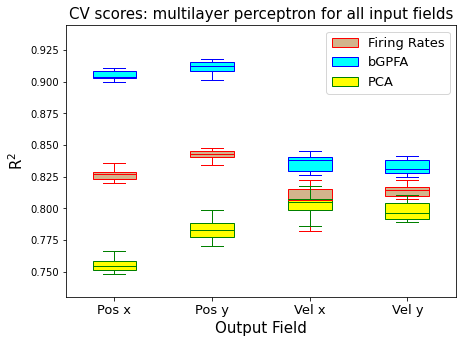

In [119]:
# storing cv scores for multilayer perceptron using the latents inferred by bGPFA 

cv_Scores_pos_x_bGPFA_dense=[0.90266784, 0.90416718, 0.89411377, 0.91125901, 0.9040912 , 
                         0.91063216, 0.90377206, 0.8999881, 0.90308366, 0.90998883]
cv_Scores_pos_y__bGPFA_dense=[0.91107405, 0.90752551, 0.91611816, 0.9179606 , 0.90129072, 
                         0.90685204, 0.91575266, 0.9126864, 0.91614336, 0.91262264]
cv_Scores_vel_x_bGPFA_dense=[0.84147252, 0.84493773, 0.83829659, 0.8280362 , 0.82668339,
                         0.83389967, 0.83839496, 0.84568609, 0.82682146, 0.83950234]
cv_Scores_vel_y_bGPFA_dense=[0.83981888, 0.83200698, 0.83086756, 0.83797048, 0.82757726, 
                         0.82699451, 0.83052307, 0.8247067 , 0.83800264, 0.84115639]

# COMPARATIVE BOXPLOT of CV SCORES for LINEAR REGRESSION 
# CROSS-COMPARISON AMONST 3 INPUT FIELDS FOR the MULTILAYER PERCEPTRON 

cv_rates_dense = [cv_pos_x_rates_dense,cv_pos_y_rates_dense, cv_vel_x_rates_dense, cv_vel_y_rates_dense ]
cv_pcs_dense = [cv_pos_x_pcs_dense,cv_pos_y_pcs_dense, cv_vel_x_pcs_dense,cv_vel_y_pcs_dense ]
cv_bGPFA_dense = [cv_Scores_pos_x_bGPFA_dense, cv_Scores_pos_y_bGPFA_dense, cv_Scores_vel_x_bGPFA_dense, cv_Scores_vel_y__bGPFA_dense]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_dense, 'red', 'tan')
bp2 = box_plot(cv_bGPFA_dense, 'blue', 'cyan')
bp3 = box_plot(cv_pcs_dense, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Firing Rates', 'bGPFA', 'PCA'], fontsize=13)
ax.set_ylim(0.73, 0.945)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron for all input fields', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('Dense_COMPARISON_FIELDS.jpeg')

COMPUTING PREDICTIONS 

In [228]:
# USING RATES 

neural_data = all_rates # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)
Y_flat=Y.reshape(Y.shape[0],(Y.shape[1]*Y.shape[2]))
Y_flat.shape #(100000, 462) Time all trials x Neurons at all time bins  

X_train=Y_flat[10:90000, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y_flat[90000:99999, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_dense.fit(X_train, y_train)

#Test model 
y_test_predicted_dense_rates=model_dense.predict(X_test)
R2s_dense_test_rates=get_R2(y_test, y_test_predicted_dense_rates)
print('R2s:', R2s_dense_test_rates) 

R2s: [0.67001852 0.69961103]


In [229]:
# USING LATENTS 

neural_data = all_pcs # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)
Y_flat=Y.reshape(Y.shape[0],(Y.shape[1]*Y.shape[2]))
Y_flat.shape #(100000, 462) Time all trials x Neurons at all time bins  

X_train=Y_flat[10:90000, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y_flat[90000:99999, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_dense.fit(X_train, y_train)

#Test model 
y_test_predicted_dense_pcs=model_dense.predict(X_test)
R2s_dense_test_pcs=get_R2(y_test, y_test_predicted_dense_pcs)
print('R2s:', R2s_dense_test_pcs) 

R2s: [0.614169   0.67104342]


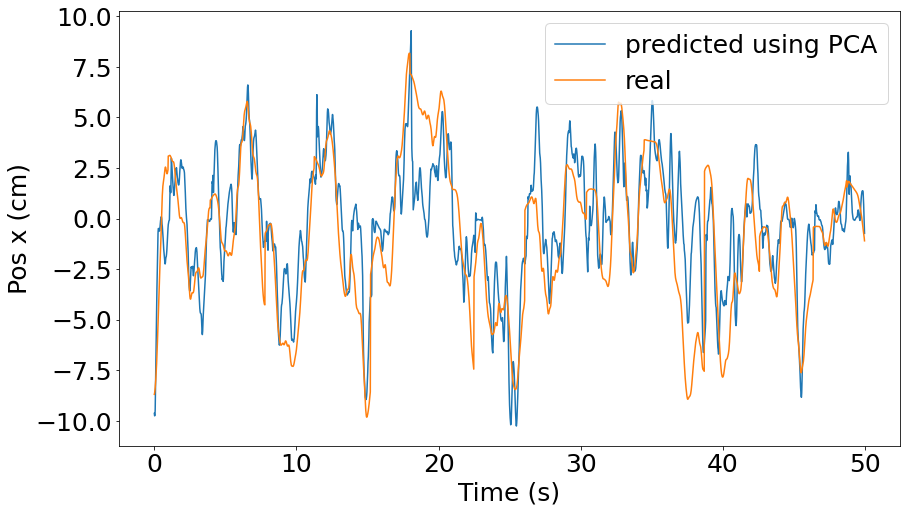

In [230]:
# real vs predicted hand trajectory in x - predicted by multilayer perceptron based on the latents found by PCA

time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_pcs[0:2500, 0]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n multilayer based on latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_x_PCA.jpeg')

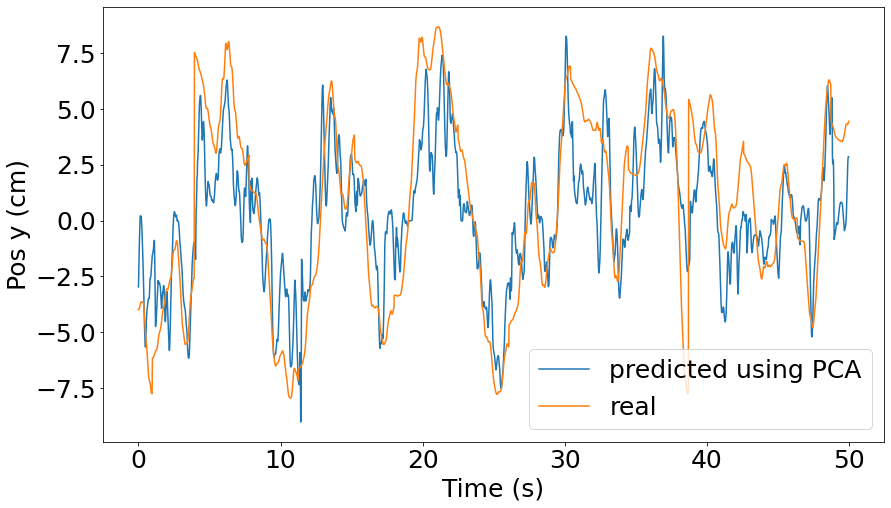

In [231]:
# real vs predicted hand trajectory in y - predicted by multilayer perceptron based on the latents found by PCA

time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_pcs[0:2500, 1]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using PCA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in y for 25% of testing data: \n multilayer based on latents found by PCA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_y_PCA.jpeg')

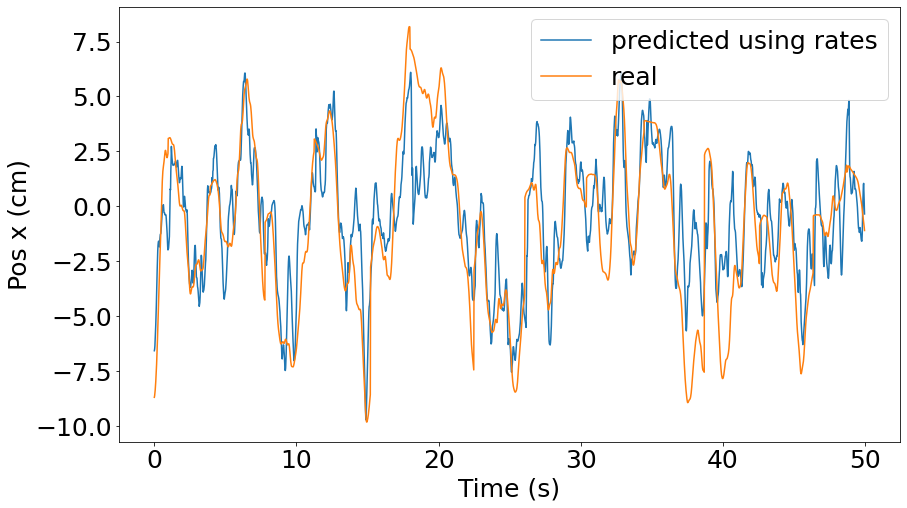

In [232]:
# real vs predicted hand trajectory in x - predicted by multilayer perceptron based on the smoothed rates

time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_rates[0:2500, 0]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n multilayer based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_x_Rates.jpeg')

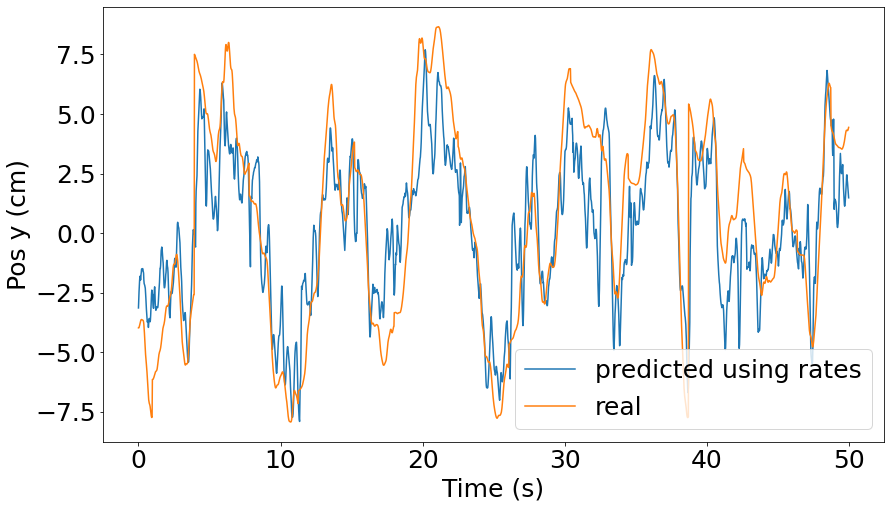

In [233]:
# real vs predicted hand trajectory in y - predicted by multilayer perceptron based on the smoothed rates

time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_rates[0:2500, 1]) 
# plt.plot(y_predict_pcs_lr[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using rates','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
#plt.title('Real & predicted hand position in y for 25% of testing data: \n multilayer based on the smoothed rates', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_y_Rates.jpeg')

Text(0.5, 1.0, 'Hand position in x for 25-30% testing data')

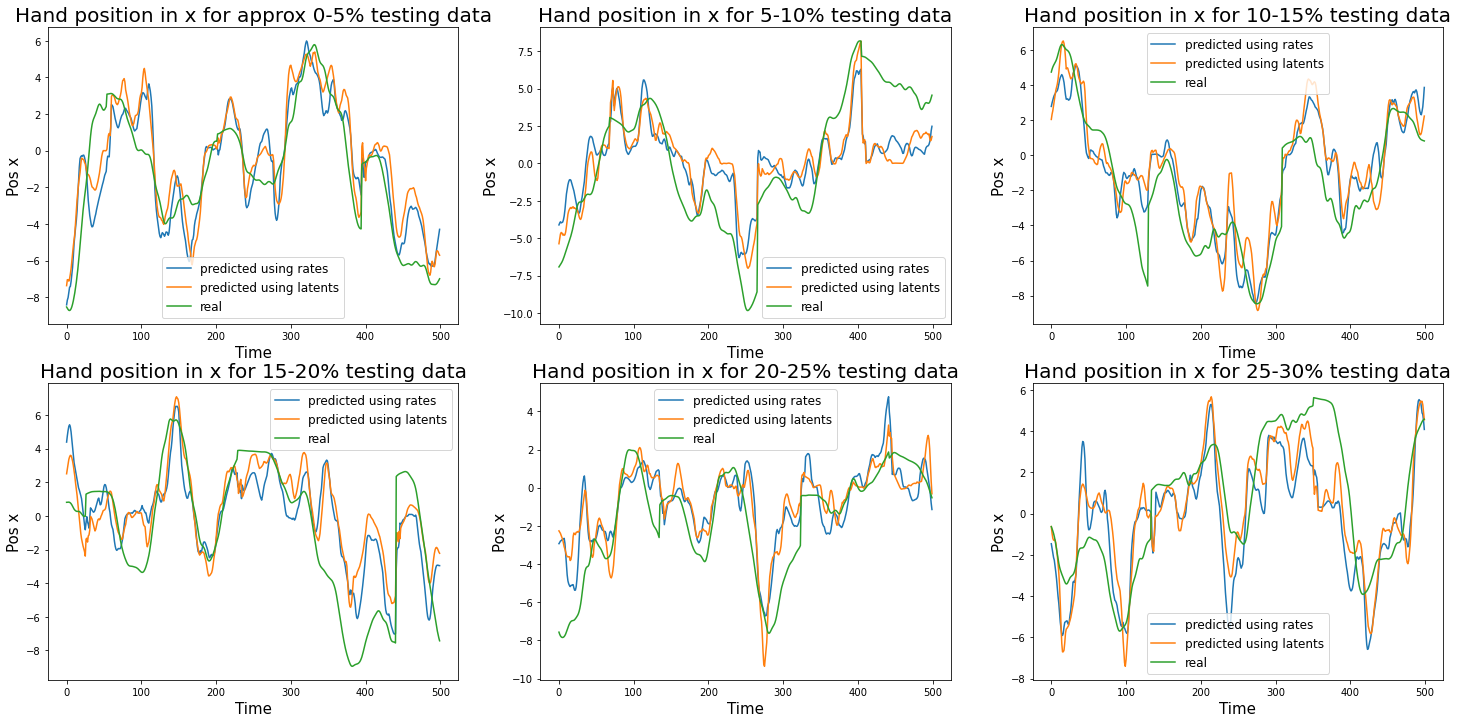

In [133]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_dense_rates[0:500, 0]) 
ax[0][0].plot(y_test_predicted_dense_pcs[0:500, 0]) 
ax[0][0].plot(y_test[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_dense_rates[500:1000, 0]) 
ax[0][1].plot(y_test_predicted_dense_pcs[500:1000, 0]) 
ax[0][1].plot(y_test[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_dense_rates[1000:1500, 0]) 
ax[0][2].plot(y_test_predicted_dense_pcs[1000:1500, 0]) 
ax[0][2].plot(y_test[1000:1500, 0])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos x', fontsize=15)
ax[0][2].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_dense_rates[1500:2000, 0]) 
ax[1][0].plot(y_test_predicted_dense_pcs[1500:2000, 0]) 
ax[1][0].plot(y_test[1500:2000, 0])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_dense_rates[2000:2500, 0]) 
ax[1][1].plot(y_test_predicted_dense_pcs[2000:2500, 0]) 
ax[1][1].plot(y_test[2000:2500, 0])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_dense_rates[2500:3000, 0]) 
ax[1][2].plot(y_test_predicted_dense_pcs[2500:3000, 0]) 
ax[1][2].plot(y_test[2500:3000, 0])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos x', fontsize=15)
ax[1][2].set_title('Hand position in x for 25-30% testing data', fontsize=20)

Text(0.5, 1.0, 'Hand position in y for 25-30% testing data')

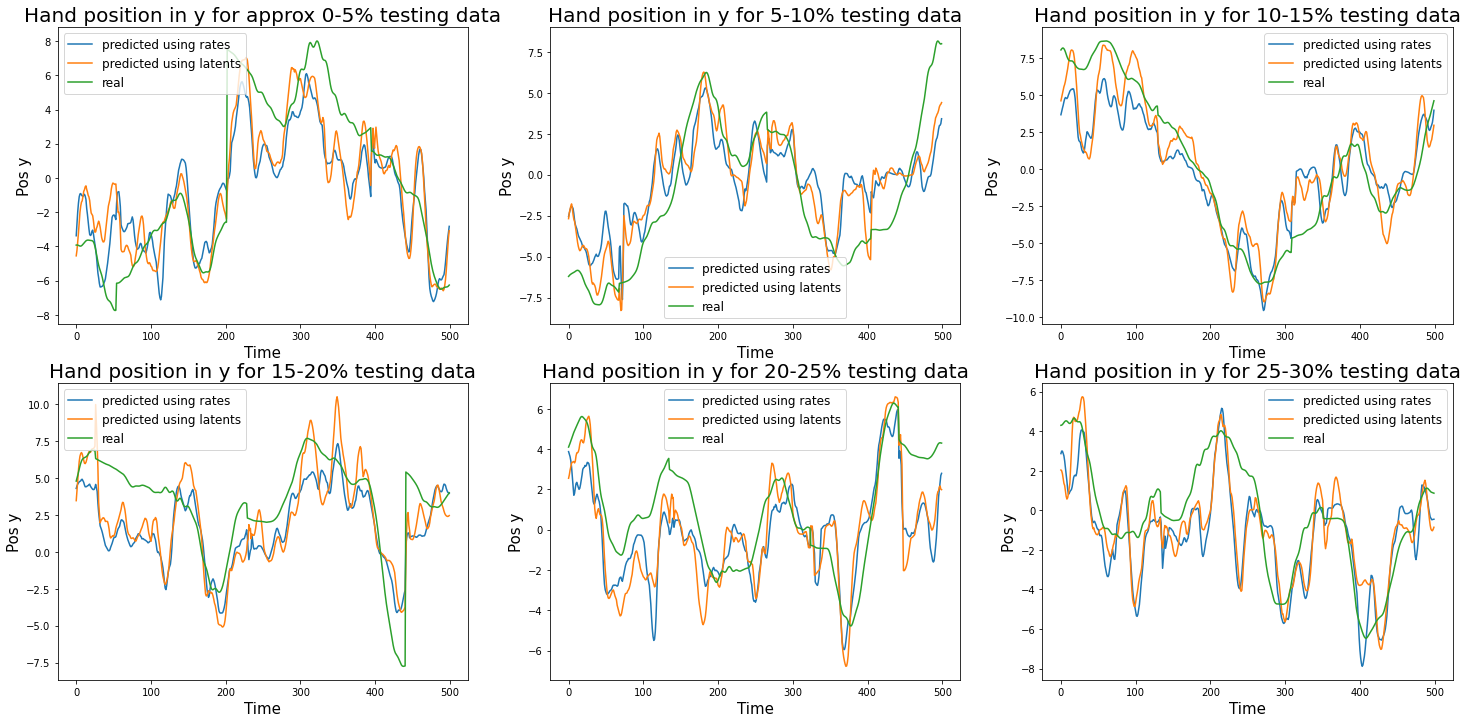

In [134]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_dense_rates[0:500, 1]) 
ax[0][0].plot(y_test_predicted_dense_pcs[0:500, 1]) 
ax[0][0].plot(y_test[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_dense_rates[500:1000, 1]) 
ax[0][1].plot(y_test_predicted_dense_pcs[500:1000, 1]) 
ax[0][1].plot(y_test[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_dense_rates[1000:1500, 1]) 
ax[0][2].plot(y_test_predicted_dense_pcs[1000:1500, 1]) 
ax[0][2].plot(y_test[1000:1500, 1])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos y', fontsize=15)
ax[0][2].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_dense_rates[1500:2000, 1]) 
ax[1][0].plot(y_test_predicted_dense_pcs[1500:2000, 1]) 
ax[1][0].plot(y_test[1500:2000, 1])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_dense_rates[2000:2500, 1]) 
ax[1][1].plot(y_test_predicted_dense_pcs[2000:2500, 1]) 
ax[1][1].plot(y_test[2000:2500, 1])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_dense_rates[2500:3000, 1]) 
ax[1][2].plot(y_test_predicted_dense_pcs[2500:3000, 1]) 
ax[1][2].plot(y_test[2500:3000, 1])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos y', fontsize=15)
ax[1][2].set_title('Hand position in y for 25-30% testing data', fontsize=20)

In [143]:
with open("file.txt", 'r') as f:
    cv_latents_bGPFA_hist = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
cv_latents_bGPFA_hist

['[0.65629053 0.64713005 0.65166572 0.64957239 0.63896023 0.64596978',
 ' 0.65910949 0.64648526 0.64324682 0.64627886]',
 '[0.70320747 0.69775654 0.70246906 0.70972826 0.70567342 0.70557794',
 ' 0.70261787 0.70660561 0.70291617 0.69704349]',
 '[0.619568   0.61179786 0.61741038 0.62084735 0.61195266 0.61820548',
 ' 0.61794666 0.61601891 0.61203508 0.61859402]',
 '[0.62978779 0.63969121 0.63110648 0.63838007 0.6428712  0.62290938',
 ' 0.6347137  0.63841247 0.63671569 0.63439683]']

In [98]:
# opening the files for the cv scores for linear regression based on bGPFA-inferred latents 


with open("file1.txt", 'r') as f:
    cv_scores_X_hist_posx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posx=[float(s) for s in cv_scores_X_hist_posx_b]
bGPFA_cv_scores_X_hist_posx

with open("file2.txt", 'r') as f:
    cv_scores_X_hist_posy_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posy=[float(s) for s in cv_scores_X_hist_posy_b]
bGPFA_cv_scores_X_hist_posy

with open("file3.txt", 'r') as f:
    cv_scores_X_hist_velx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_velx=[float(s) for s in cv_scores_X_hist_velx_b]
bGPFA_cv_scores_X_hist_velx

with open("file4.txt", 'r') as f:
    cv_scores_X_hist_vely_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_vely=[float(s) for s in cv_scores_X_hist_vely_b]
# bGPFA_cv_scores_X_hist_vely

[0.6297877935841064,
 0.639691206990826,
 0.6311064771109816,
 0.6383800681576519,
 0.6428711999497684,
 0.6229093779798568,
 0.6347137010191225,
 0.6384124681439813,
 0.6367156902930752,
 0.6343968259633039]

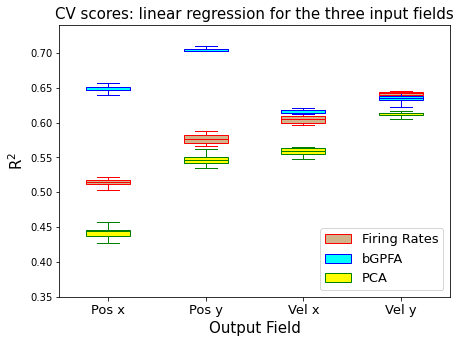

In [102]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

cv_latents_bGPFA_hist = [bGPFA_cv_scores_X_hist_posx,bGPFA_cv_scores_X_hist_posy, bGPFA_cv_scores_X_hist_velx, bGPFA_cv_scores_X_hist_vely ]
cv_pcs_hist = [cv_scores_X_hist_posx,cv_scores_X_hist_posy, cv_scores_X_hist_velx, cv_scores_X_hist_vely ]
cv_rates_hist = [cv_scores_F_hist_posx,cv_scores_F_hist_posy, cv_scores_F_hist_velx, cv_scores_F_hist_vely ]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_hist, 'red', 'tan')
bp2 = box_plot(cv_latents_bGPFA_hist, 'blue', 'cyan')
bp3 = box_plot(cv_pcs_hist, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0],], ['Firing Rates', 'bGPFA', 'PCA'], fontsize=13)
ax.set_ylim(0.35, 0.74)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression for the three input fields', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LR_COMPARISON_FIELDS.jpeg')

# GENERATING GRAPHS OF OVERVIEW 

RESULTS FOR LINEAR REGRESSION 

In [103]:
cv_scores_F_hist_vel = cross_val_score(LinearRegression(), rates_hist_matrix, vel_hist, cv = KFold(10, shuffle=True))
cv_scores_F_hist_pos = cross_val_score(LinearRegression(), rates_hist_matrix, locs_hist, cv = KFold(10, shuffle=True))


In [104]:
cv_scores_F_hist_vel
# [0.59517431, 0.59577665, 0.5971724 , 0.59753981, 0.60489406, 0.60116229, 0.60108194, 0.60800012, 0.59783513, 0.59832299]
cv_scores_F_hist_pos
# [0.53758498, 0.53558373, 0.53824976, 0.53609473, 0.54092968, 0.53768023, 0.5355213 , 0.53360737, 0.54344144, 0.54593732]

array([0.53810619, 0.53607999, 0.54264947, 0.5394025 , 0.54649206,
       0.54914226, 0.54378734, 0.54440066, 0.55543672, 0.55055398])

In [105]:
cv_scores_X_hist_vel = cross_val_score(LinearRegression(), pcs_hist_matrix, vel_hist, cv = KFold(10, shuffle=True))
cv_scores_X_hist_pos = cross_val_score(LinearRegression(), pcs_hist_matrix, locs_hist, cv = KFold(10, shuffle=True))

In [106]:
cv_scores_X_hist_vel
# [0.56272163, 0.56358286, 0.55773904, 0.55792379, 0.55472012, 0.55826143, 0.55247986, 0.54520995, 0.5544228 , 0.55614055]
cv_scores_X_hist_pos
# [0.48609778, 0.47710896, 0.48336781, 0.4797546 , 0.4895322 , 0.48956223, 0.47709588, 0.48441012, 0.48948826, 0.4900212 ]

array([0.49884593, 0.49753267, 0.49182796, 0.50200915, 0.49351314,
       0.49355896, 0.50019515, 0.4871869 , 0.48960207, 0.48923468])

In [107]:
with open("file1.txt", 'r') as f:
    cv_scores_X_hist_posx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posx=[float(s) for s in cv_scores_X_hist_posx_b]
bGPFA_cv_scores_X_hist_posx

with open("file2.txt", 'r') as f:
    cv_scores_X_hist_posy_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_posy=[float(s) for s in cv_scores_X_hist_posy_b]
bGPFA_cv_scores_X_hist_posy

with open("file3.txt", 'r') as f:
    cv_scores_X_hist_velx_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_velx=[float(s) for s in cv_scores_X_hist_velx_b]
bGPFA_cv_scores_X_hist_velx

with open("file4.txt", 'r') as f:
    cv_scores_X_hist_vely_b = [line.rstrip('\n') for line in f]
#scores=[int(s) for s in cv_latents_bGPFA_hist]
#scores
bGPFA_cv_scores_X_hist_vely=[float(s) for s in cv_scores_X_hist_vely_b]


In [108]:
bGPFA_cv_scores_X_hist_vel=[]
bGPFA_cv_scores_X_hist_pos=[]
for i in range(0, 9): 
    a=(bGPFA_cv_scores_X_hist_velx[i]+bGPFA_cv_scores_X_hist_vely[i])/2
    b=(bGPFA_cv_scores_X_hist_posx[i]+bGPFA_cv_scores_X_hist_posy[i])/2
    bGPFA_cv_scores_X_hist_vel.append(a)
    bGPFA_cv_scores_X_hist_pos.append(b)
    
bGPFA_cv_scores_X_hist_vel 
# [0.6246778972816267, 0.6257445355122451, 0.6242584310287522, 0.6296137090570635, 0.6274119275070758, 0.6205574277860388, 0.6263301826463914, 0.6272156871573673,0.6243753845520992]
bGPFA_cv_scores_X_hist_pos
# [0.5627071673557927, 0.5678916057550625, 0.5744711625196712, 0.5735952143392251, 0.5686493215333313, 0.5748948729066929, 0.5797280668924405, 0.5659557333662835, 0.5721323385119064]

[0.6797490017444757,
 0.6724432952555099,
 0.6770673887674211,
 0.6796503271605008,
 0.6723168244613723,
 0.6757738608918549,
 0.6808636777956802,
 0.6765454374712296,
 0.6730814946471944]

RESULTS FOR LSTM 

In [109]:
cv_vel_x_rates_lstm=[0.95597108,0.95001408,0.95340578,0.94936236,0.95595663,0.95581072,0.95881756,
                  0.95120518,0.95268704,0.95114964]
cv_vel_y_rates_lstm=[0.95097876, 0.94883948, 0.95012732, 0.94690591, 0.95220971, 0.94763706, 0.95055216, 
                  0.94630818, 0.95205219, 0.94769666]
cv_pos_x_rates_lstm=[0.97745602, 0.97567137, 0.97580711, 0.97434582, 0.9749096 , 0.97575527, 0.97359311, 
                   0.97334644, 0.97756795, 0.97686266]
cv_pos_y_rates_lstm=[0.97748025, 0.97849039, 0.97772142, 0.9791986, 0.97875781, 0.97805503, 0.97772923,
                   0.97805531, 0.97994865, 0.9813002]

cv_vel_rates_lstm=[]
cv_pos_rates_lstm=[]
for i in range(0, 9): 
    a=(cv_vel_x_rates_lstm[i]+cv_vel_y_rates_lstm[i])/2
    b=(cv_pos_x_rates_lstm[i]+cv_pos_y_rates_lstm[i])/2
    cv_vel_rates_lstm.append(a)
    cv_pos_rates_lstm.append(b)
    
cv_vel_rates_lstm
# [0.95347492, 0.94942678, 0.95176655, 0.948134135, 0.95408317, 0.95172389, 0.95468486,0.94875668,0.9523696150000001]

cv_pos_rates_lstm
# [0.9774681350000001,0.97708088,0.9767642649999999,0.97677221,0.976833705,0.97690515,0.97566117,0.975700875,0.9787583]

[0.9774681350000001,
 0.97708088,
 0.9767642649999999,
 0.97677221,
 0.976833705,
 0.97690515,
 0.97566117,
 0.975700875,
 0.9787583]

In [110]:
cv_vel_x_pcs_lstm=[0.96255548, 0.95973464, 0.9598874 , 0.96243119, 0.96090319, 0.96223392, 0.96197628, 
                          0.96100978, 0.96276608, 0.96212506]
cv_vel_y_pcs_lstm=[0.95776219, 0.95696231, 0.95811964, 0.95990905, 0.9609399 , 0.95951015, 
                          0.95792669, 0.95902386, 0.96056491, 0.9569561]
cv_pos_x_pcs_lstm=[0.97974532, 0.97808459, 0.97886193, 0.97954095, 0.97861696, 0.97881041, 
                          0.97956185, 0.98063652, 0.97905856, 0.97960072]
cv_pos_y_pcs_lstm=[0.9807244 , 0.98005306, 0.98177455, 0.98014698, 0.98126859, 0.98143323, 
                          0.98209167, 0.9821061 , 0.9820066 , 0.98064705]
cv_vel_pcs_lstm=[]
cv_pos_pcs_lstm=[]
for i in range(0, 9): 
    a=(cv_vel_x_pcs_lstm[i]+cv_vel_y_pcs_lstm[i])/2
    b=(cv_pos_x_pcs_lstm[i]+cv_pos_y_pcs_lstm[i])/2
    cv_vel_pcs_lstm.append(a)
    cv_pos_pcs_lstm.append(b)
cv_vel_pcs_lstm
#[0.960158835,0.958348475,0.95900352,0.96117012,0.9609215449999999,0.960872035,0.9599514849999999,0.96001682,0.961665495]
cv_pos_pcs_lstm
# [0.98023486,0.979068825,0.98031824,0.9798439649999999,0.979942775,0.98012182,0.98082676,0.98137131,0.98053258]


[0.98023486,
 0.979068825,
 0.98031824,
 0.9798439649999999,
 0.979942775,
 0.98012182,
 0.98082676,
 0.98137131,
 0.98053258]

In [111]:
bGPFA_cv_scores_vel_x_lstm=[0.92140937, 0.92368591, 0.91340234, 0.91316433, 0.91654864, 
                         0.91306687, 0.92118182, 0.92222493, 0.92290897, 0.9133583]
bGPFA_cv_scores_vel_y_lstm=[0.91351966, 0.91452149, 0.90511381, 0.90971211, 0.91054961, 
                         0.90250338, 0.91143649, 0.91987674, 0.91372856, 0.9117656]
bGPFA_cv_scores_pos_x_lstm=[0.98197556, 0.98131631, 0.98224821, 0.98336054, 0.98361033, 
                         0.98121074, 0.9824812 , 0.98194076, 0.98345611, 0.98049719]
bGPFA_cv_scores_pos_y_lstm=[0.98451036, 0.98473229, 0.98313725, 0.98607687, 0.98458969, 
                         0.984394  , 0.98445498, 0.98483623, 0.98325001, 0.98377365]

bGPFA_cv_vel_lstm=[]
bGPFA_cv_pos_lstm=[]
for i in range(0, 9): 
    a=(bGPFA_cv_scores_vel_x_lstm[i]+bGPFA_cv_scores_vel_y_lstm[i])/2
    b=(bGPFA_cv_scores_pos_x_lstm[i]+bGPFA_cv_scores_pos_y_lstm[i])/2
    bGPFA_cv_vel_lstm.append(a)
    bGPFA_cv_pos_lstm.append(b)
bGPFA_cv_vel_lstm
# [0.917464515,0.9191037, 0.909258075, 0.91143822, 0.9135491250000001, 0.907785125, 0.916309155, 0.921050835,0.918318765]
bGPFA_cv_pos_lstm
#[0.98324296, 0.9830243, 0.9826927299999999, 0.9847187049999999, 0.9841000099999999, 0.9828023699999999, 0.98346809, 0.983388495,0.98335306]


[0.98324296,
 0.9830243,
 0.9826927299999999,
 0.9847187049999999,
 0.9841000099999999,
 0.9828023699999999,
 0.98346809,
 0.983388495,
 0.98335306]

RESULTS FOR DENSE 

In [112]:
cv_vel_x_rates_dense=[0.80441954, 0.79928293, 0.80357315, 0.81350946, 0.80898845, 0.78428285, 
                0.82245284, 0.82039151, 0.7824337 , 0.81587852]
cv_vel_y_rates_dense=[0.81500518, 0.81888135, 0.75859067, 0.81360276, 0.81469663, 0.81696609, 
                0.81211475, 0.82218446, 0.80848091, 0.80730602]
cv_pos_x_rates_dense=[0.8233847 , 0.82906518, 0.82345953, 0.82028517, 0.82678134, 0.81013378, 
                0.82723866, 0.83613947, 0.83983654, 0.82735873]
cv_pos_y_rates_dense=[0.84024272, 0.83561525, 0.83405889, 0.84231822, 0.84800925, 0.84162517, 
                0.84535497, 0.84556877, 0.84294712, 0.84398514]

cv_vel_rates_dense=[]
cv_pos_rates_dense=[]
for i in range(0, 9): 
    a=(cv_vel_x_rates_dense[i]+cv_vel_y_rates_dense[i])/2
    b=(cv_pos_x_rates_dense[i]+cv_pos_y_rates_dense[i])/2
    cv_vel_rates_dense.append(a)
    cv_pos_rates_dense.append(b)
cv_vel_rates_dense
# [0.80971236,0.8090821399999999,0.7810819099999999,0.8135561099999999,0.81184254,0.80062447,0.817283795,0.821287985,0.795457305]
cv_pos_rates_dense
#[0.83181371, 0.832340215, 0.8287592100000001,0.8313016950000001,0.8373952950000001,0.825879475,0.8362968150000001,0.8408541199999999,0.8413918300000001]


[0.83181371,
 0.832340215,
 0.8287592100000001,
 0.8313016950000001,
 0.8373952950000001,
 0.825879475,
 0.8362968150000001,
 0.8408541199999999,
 0.8413918300000001]

In [113]:
cv_vel_x_pcs_dense=[0.80799383, 0.80436695, 0.81738748, 0.79559023, 0.80233594, 0.78571621, 
              0.79753201, 0.80495206, 0.80838966, 0.80580045]
cv_vel_y_pcs_dense=[0.80455076, 0.78880083, 0.79638452, 0.78943257, 0.81037752, 0.80227519, 
              0.79149323, 0.80432656, 0.79291125, 0.795676 ]
cv_pos_x_pcs_dense=[0.75607866, 0.73734639, 0.76155067, 0.75910278, 0.74834655, 0.75275754, 
              0.75673328, 0.7659472, 0.7507867 , 0.75227577]
cv_pos_y_pcs_dense=[0.77024936, 0.7794667 , 0.78134116, 0.79755761, 0.77641576, 0.78696633, 
              0.78504122, 0.7576299, 0.78901215, 0.79893567]

cv_vel_pcs_dense=[]
cv_pos_pcs_dense=[]
for i in range(0, 9): 
    a=(cv_vel_x_pcs_dense[i]+cv_vel_y_pcs_dense[i])/2
    b=(cv_pos_x_pcs_dense[i]+cv_pos_y_pcs_dense[i])/2
    cv_vel_pcs_dense.append(a)
    cv_pos_pcs_dense.append(b)
cv_vel_pcs_dense
# [0.8062722950000001,0.79658389,0.806886,0.7925114,0.80635673,0.7939957,0.79451262,0.80463931,0.800650455]
cv_pos_pcs_dense
# [0.76316401,0.7584065449999999,0.7714459149999999,0.778330195,0.762381155,0.769861935,0.7708872499999999,0.76178855,0.769899425]


[0.76316401,
 0.7584065449999999,
 0.7714459149999999,
 0.778330195,
 0.762381155,
 0.769861935,
 0.7708872499999999,
 0.76178855,
 0.769899425]

In [114]:
bGPFA_cv_scores_pos_x_dense=[0.90266784, 0.90416718, 0.89411377, 0.91125901, 0.9040912 , 
                         0.91063216, 0.90377206, 0.8999881, 0.90308366, 0.90998883]
bGPFA_cv_scores_pos_y_dense=[0.91107405, 0.90752551, 0.91611816, 0.9179606 , 0.90129072, 
                         0.90685204, 0.91575266, 0.9126864, 0.91614336, 0.91262264]
bGPFA_cv_scores_vel_x_dense=[0.84147252, 0.84493773, 0.83829659, 0.8280362 , 0.82668339,
                         0.83389967, 0.83839496, 0.84568609, 0.82682146, 0.83950234]
bGPFA_cv_scores_vel_y_dense=[0.83981888, 0.83200698, 0.83086756, 0.83797048, 0.82757726, 
                         0.82699451, 0.83052307, 0.8247067 , 0.83800264, 0.84115639]

bGPFA_cv_vel_dense=[]
bGPFA_cv_pos_dense=[]
for i in range(0, 9): 
    a=(bGPFA_cv_scores_vel_x_dense[i]+bGPFA_cv_scores_vel_y_dense[i])/2
    b=(bGPFA_cv_scores_pos_x_dense[i]+bGPFA_cv_scores_pos_y_dense[i])/2
    bGPFA_cv_vel_dense.append(a)
    bGPFA_cv_pos_dense.append(b)
bGPFA_cv_vel_dense
#[0.8406457, 0.838472355, 0.8345820749999999, 0.83300334, 0.8271303249999999, 0.83044709, 0.834459015,0.835196395,0.8324120500000001]
bGPFA_cv_pos_dense
#[0.906870945, 0.905846345, 0.905115965, 0.914609805, 0.9026909599999999,0.9087421,0.90976236,0.90633725,0.90961351]


[0.906870945,
 0.905846345,
 0.905115965,
 0.914609805,
 0.9026909599999999,
 0.9087421,
 0.90976236,
 0.90633725,
 0.90961351]

In [115]:
cv_pos_linear = [cv_scores_F_hist_pos, cv_scores_X_hist_pos, bGPFA_cv_scores_X_hist_pos]
cv_pos_lstm = [cv_pos_rates_lstm, cv_pos_pcs_lstm, bGPFA_cv_pos_lstm]
cv_pos_dense = [cv_pos_rates_dense, cv_pos_pcs_dense, bGPFA_cv_pos_dense]

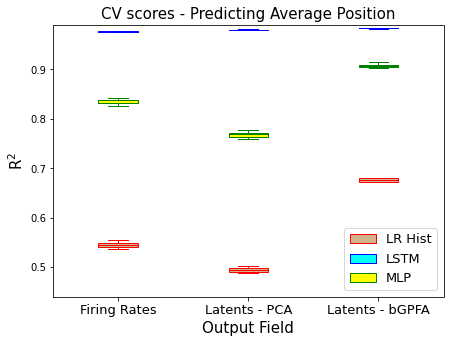

In [116]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_pos_linear, 'red', 'tan')
bp2 = box_plot(cv_pos_lstm, 'blue', 'cyan')
bp3 = box_plot(cv_pos_dense, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['LR Hist', 'LSTM', 'MLP'], fontsize=13)
ax.set_ylim(0.44, 0.99)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores - Predicting Average Position', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3], ['Firing Rates', 'Latents - PCA', 'Latents - bGPFA'], fontsize=13)
plt.savefig('Summative_Position.jpeg')

In [117]:
cv_vel_linear = [cv_scores_F_hist_vel, cv_scores_X_hist_vel, bGPFA_cv_scores_X_hist_vel]
cv_vel_lstm = [cv_vel_rates_lstm, cv_vel_pcs_lstm, bGPFA_cv_vel_lstm]
cv_vel_dense = [cv_vel_rates_dense, cv_vel_pcs_dense, bGPFA_cv_vel_dense]

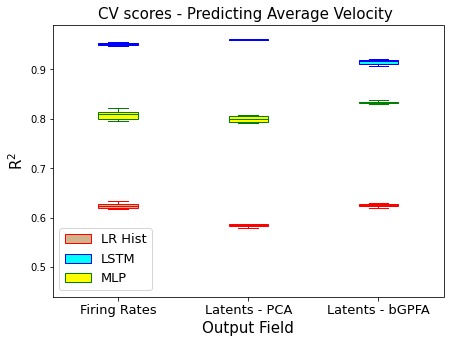

In [118]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_vel_linear, 'red', 'tan')
bp2 = box_plot(cv_vel_lstm, 'blue', 'cyan')
bp3 = box_plot(cv_vel_dense, 'green', 'yellow')
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['LR Hist', 'LSTM', 'MLP'], fontsize=13)
ax.set_ylim(0.44, 0.99)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores - Predicting Average Velocity ', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3], ['Firing Rates', 'Latents - PCA', 'Latents - bGPFA'], fontsize=13)
plt.savefig('Summative_Velocity.jpeg')